# Assignment: Programming for Business Analytics

## 274403, 447382, 457086

## Import Libraries

In [1]:
import pandas as pd
import polars as pl
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
# from transformers import pipeline
# import tensorflow as tf
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
import plotly.express as px
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker


## Read Dataset into DataFrame

Data Set Info:

This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

In [2]:
df_2009_2010 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2009-2010')
df_2010_2011 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011')

In [3]:
df = pd.concat([df_2009_2010, df_2010_2011], ignore_index=True)
df 

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [4]:
# add pandas profiling here

In [5]:
# check nulls
print(df.isnull().sum())

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64


In [6]:
# Was unable to read excel as polars df due to mixed data type values in single cols 
# want to preserve nulls as nulls for later investigation/preprocessing

for col in df.columns:
    if df[col].dtype == 'object':  # Likely mixed types
        # Preserve nulls while converting other values to string
        df[col] = df[col].apply(lambda x: str(x) if pd.notnull(x) else pd.NA)
        


In [7]:
print(df.isnull().sum()) # null counts remain the same per col 

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64


In [8]:
# Cast InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [9]:
# Summary Statistics
pd.options.display.float_format = '{:.2f}'.format
print(df.describe())

        Quantity                    InvoiceDate      Price  Customer ID
count 1067371.00                        1067371 1067371.00    824364.00
mean        9.94  2011-01-02 21:13:55.394028544       4.65     15324.64
min    -80995.00            2009-12-01 07:45:00  -53594.36     12346.00
25%         1.00            2010-07-09 09:46:00       1.25     13975.00
50%         3.00            2010-12-07 15:28:00       2.10     15255.00
75%        10.00            2011-07-22 10:23:00       4.15     16797.00
max     80995.00            2011-12-09 12:50:00   38970.00     18287.00
std       172.71                            NaN     123.55      1697.46


In [10]:
# Correlation of Price and Quantity
df['Price'].corr(df['Quantity'], method='spearman')

np.float64(-0.3989842490986822)

In [11]:
# convert pandas df to polars df
# did this for convenience in feature engineering later and speed
df = pl.from_pandas(df)
df 

Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
str,str,str,i64,datetime[ns],f64,f64,str
"""489434""","""85048""","""15CM CHRISTMAS GLASS BALL 20 L…",12,2009-12-01 07:45:00,6.95,13085.0,"""United Kingdom"""
"""489434""","""79323P""","""PINK CHERRY LIGHTS""",12,2009-12-01 07:45:00,6.75,13085.0,"""United Kingdom"""
"""489434""","""79323W""",""" WHITE CHERRY LIGHTS""",12,2009-12-01 07:45:00,6.75,13085.0,"""United Kingdom"""
"""489434""","""22041""","""RECORD FRAME 7"" SINGLE SIZE """,48,2009-12-01 07:45:00,2.1,13085.0,"""United Kingdom"""
"""489434""","""21232""","""STRAWBERRY CERAMIC TRINKET BOX""",24,2009-12-01 07:45:00,1.25,13085.0,"""United Kingdom"""
…,…,…,…,…,…,…,…
"""581587""","""22899""","""CHILDREN'S APRON DOLLY GIRL """,6,2011-12-09 12:50:00,2.1,12680.0,"""France"""
"""581587""","""23254""","""CHILDRENS CUTLERY DOLLY GIRL """,4,2011-12-09 12:50:00,4.15,12680.0,"""France"""
"""581587""","""23255""","""CHILDRENS CUTLERY CIRCUS PARAD…",4,2011-12-09 12:50:00,4.15,12680.0,"""France"""


In [12]:
pl.Config.set_tbl_rows(None)
pl.Config.set_tbl_cols(None)

polars.config.Config

In [13]:
# check nulls
df.null_count()

Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
u32,u32,u32,u32,u32,u32,u32,u32
0,0,4382,0,0,0,243007,0


In [14]:
df.filter(
    (pl.col('Description').is_null())
)

Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
str,str,str,i64,datetime[ns],f64,f64,str
"""489521""","""21646""",null,-50,2009-12-01 11:44:00,0.0,null,"""United Kingdom"""
"""489655""","""20683""",null,-44,2009-12-01 17:26:00,0.0,null,"""United Kingdom"""
"""489659""","""21350""",null,230,2009-12-01 17:39:00,0.0,null,"""United Kingdom"""
"""489781""","""84292""",null,17,2009-12-02 11:45:00,0.0,null,"""United Kingdom"""
"""489806""","""18010""",null,-770,2009-12-02 12:42:00,0.0,null,"""United Kingdom"""
…,…,…,…,…,…,…,…
"""581199""","""84581""",null,-2,2011-12-07 18:26:00,0.0,null,"""United Kingdom"""
"""581203""","""23406""",null,15,2011-12-07 18:31:00,0.0,null,"""United Kingdom"""
"""581209""","""21620""",null,6,2011-12-07 18:35:00,0.0,null,"""United Kingdom"""


In [15]:
# df.select(pl.col('Description')).unique()

# Data Preprocessing

In [16]:
# Fill null values under Description with "Unclear"
df = df.with_columns(
    df["Description"].fill_null("Unclear")
)

df 

Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
str,str,str,i64,datetime[ns],f64,f64,str
"""489434""","""85048""","""15CM CHRISTMAS GLASS BALL 20 L…",12,2009-12-01 07:45:00,6.95,13085.0,"""United Kingdom"""
"""489434""","""79323P""","""PINK CHERRY LIGHTS""",12,2009-12-01 07:45:00,6.75,13085.0,"""United Kingdom"""
"""489434""","""79323W""",""" WHITE CHERRY LIGHTS""",12,2009-12-01 07:45:00,6.75,13085.0,"""United Kingdom"""
"""489434""","""22041""","""RECORD FRAME 7"" SINGLE SIZE """,48,2009-12-01 07:45:00,2.1,13085.0,"""United Kingdom"""
"""489434""","""21232""","""STRAWBERRY CERAMIC TRINKET BOX""",24,2009-12-01 07:45:00,1.25,13085.0,"""United Kingdom"""
…,…,…,…,…,…,…,…
"""581587""","""22899""","""CHILDREN'S APRON DOLLY GIRL """,6,2011-12-09 12:50:00,2.1,12680.0,"""France"""
"""581587""","""23254""","""CHILDRENS CUTLERY DOLLY GIRL """,4,2011-12-09 12:50:00,4.15,12680.0,"""France"""
"""581587""","""23255""","""CHILDRENS CUTLERY CIRCUS PARAD…",4,2011-12-09 12:50:00,4.15,12680.0,"""France"""


In [17]:
# check nulls
df.null_count()

Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,243007,0


In [18]:
# But I noticed weird description values where they were just ?, ???, or other unclear characters with ? 
# Replace these with 'Unclear' 

df = df.with_columns(
    pl.when(pl.col('Description').str.contains('^\\?'))  
    .then(pl.lit('Unclear'))
    .otherwise(pl.col('Description'))
    .alias('Description')
)


df


Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
str,str,str,i64,datetime[ns],f64,f64,str
"""489434""","""85048""","""15CM CHRISTMAS GLASS BALL 20 L…",12,2009-12-01 07:45:00,6.95,13085.0,"""United Kingdom"""
"""489434""","""79323P""","""PINK CHERRY LIGHTS""",12,2009-12-01 07:45:00,6.75,13085.0,"""United Kingdom"""
"""489434""","""79323W""",""" WHITE CHERRY LIGHTS""",12,2009-12-01 07:45:00,6.75,13085.0,"""United Kingdom"""
"""489434""","""22041""","""RECORD FRAME 7"" SINGLE SIZE """,48,2009-12-01 07:45:00,2.1,13085.0,"""United Kingdom"""
"""489434""","""21232""","""STRAWBERRY CERAMIC TRINKET BOX""",24,2009-12-01 07:45:00,1.25,13085.0,"""United Kingdom"""
…,…,…,…,…,…,…,…
"""581587""","""22899""","""CHILDREN'S APRON DOLLY GIRL """,6,2011-12-09 12:50:00,2.1,12680.0,"""France"""
"""581587""","""23254""","""CHILDRENS CUTLERY DOLLY GIRL """,4,2011-12-09 12:50:00,4.15,12680.0,"""France"""
"""581587""","""23255""","""CHILDRENS CUTLERY CIRCUS PARAD…",4,2011-12-09 12:50:00,4.15,12680.0,"""France"""


In [19]:
df.filter(
    pl.col('Description') == '?'
)

Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
str,str,str,i64,datetime[ns],f64,f64,str


In [20]:
df.filter(
    pl.col('Description') == '???'
)

Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
str,str,str,i64,datetime[ns],f64,f64,str


In [21]:
df.filter(
    pl.col('Description') == '?sold as sets?'
)

Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
str,str,str,i64,datetime[ns],f64,f64,str


In [22]:
df.filter(
    pl.col('Description') == '?lost?'
)

Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
str,str,str,i64,datetime[ns],f64,f64,str


In [23]:
df.filter(
    pl.col('Description') == 'Unclear'
)

Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
str,str,str,i64,datetime[ns],f64,f64,str
"""489521""","""21646""","""Unclear""",-50,2009-12-01 11:44:00,0.0,null,"""United Kingdom"""
"""489655""","""20683""","""Unclear""",-44,2009-12-01 17:26:00,0.0,null,"""United Kingdom"""
"""489659""","""21350""","""Unclear""",230,2009-12-01 17:39:00,0.0,null,"""United Kingdom"""
"""489781""","""84292""","""Unclear""",17,2009-12-02 11:45:00,0.0,null,"""United Kingdom"""
"""489806""","""18010""","""Unclear""",-770,2009-12-02 12:42:00,0.0,null,"""United Kingdom"""
…,…,…,…,…,…,…,…
"""581203""","""23406""","""Unclear""",15,2011-12-07 18:31:00,0.0,null,"""United Kingdom"""
"""581204""","""85104""","""Unclear""",-355,2011-12-07 18:32:00,0.0,null,"""United Kingdom"""
"""581209""","""21620""","""Unclear""",6,2011-12-07 18:35:00,0.0,null,"""United Kingdom"""


In [24]:
df.filter(
    pl.col('Customer ID').is_null()
).shape[0]

243007

In [25]:
# Data types of cols seem correct

In [26]:
# add code to count duplicate rows here

# get dupes
duplicate_counts = df.group_by(df.columns).agg(pl.count().alias('count'))

# filtre out dupes
duplicates = duplicate_counts.filter(pl.col('count') > 1)
duplicates

/var/folders/pl/vldk2f117ps7jbp86h049rxc0000gn/T/ipykernel_24474/1379848172.py:4: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  duplicate_counts = df.group_by(df.columns).agg(pl.count().alias('count'))


Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,count
str,str,str,i64,datetime[ns],f64,f64,str,u32
"""537831""","""85049A""","""TRADITIONAL CHRISTMAS RIBBONS""",4,2010-12-08 14:50:00,1.25,17894.0,"""United Kingdom""",2
"""575583""","""20893""","""HANGING BAUBLE T-LIGHT HOLDER …",1,2011-11-10 11:55:00,2.55,14456.0,"""United Kingdom""",2
"""518653""","""85141""","""JARDIN ETCHED GLASS FRUITBOWL""",1,2010-08-10 13:32:00,10.75,16221.0,"""United Kingdom""",2
"""537638""","""22624""","""IVORY KITCHEN SCALES""",2,2010-12-07 15:28:00,16.98,null,"""United Kingdom""",2
"""576236""","""22383""","""LUNCH BAG SUKI DESIGN """,2,2011-11-14 13:31:00,1.65,13755.0,"""United Kingdom""",2
…,…,…,…,…,…,…,…,…
"""511655""","""22315""","""200 RED + WHITE BENDY STRAWS""",1,2010-06-09 14:09:00,1.25,14104.0,"""United Kingdom""",2
"""537672""","""22585""","""PACK OF 6 BIRDY GIFT TAGS""",12,2010-12-08 09:30:00,1.25,13050.0,"""United Kingdom""",2
"""537389""","""21260""","""FIRST AID TIN""",2,2010-12-06 13:41:00,3.25,17757.0,"""United Kingdom""",2


In [27]:
# Remove duplicate rows 
df = df.unique()
df 

Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
str,str,str,i64,datetime[ns],f64,f64,str
"""526089""","""22606""","""WOODEN SKITTLES GARDEN SET""",1,2010-10-08 12:14:00,15.95,15281.0,"""United Kingdom"""
"""547652""","""84970L""","""SINGLE HEART ZINC T-LIGHT HOLD…",24,2011-03-24 12:15:00,0.95,14606.0,"""United Kingdom"""
"""526253""","""22692""","""Unclear""",2,2010-10-11 10:24:00,0.0,null,"""United Kingdom"""
"""534378""","""22065""","""CHRISTMAS PUDDING TRINKET POT """,6,2010-11-22 12:33:00,1.45,14461.0,"""United Kingdom"""
"""545150""","""21523""","""DOORMAT FANCY FONT HOME SWEET …",2,2011-02-28 12:27:00,7.95,14227.0,"""United Kingdom"""
…,…,…,…,…,…,…,…
"""492953""","""51012C""","""FEATHER DUSTER, COAL BLACK""",12,2009-12-21 15:20:00,1.25,14505.0,"""United Kingdom"""
"""491966""","""21364""","""PEACE SMALL WOOD LETTERS""",1,2009-12-14 17:16:00,13.87,null,"""United Kingdom"""
"""575117""","""23583""","""LUNCH BAG PAISLEY PARK """,1,2011-11-08 14:22:00,1.65,12748.0,"""United Kingdom"""


In [28]:
# Remove transactions that don't make sense (e.g., price <= 0 and quantity <= 0)
# Could the negative Quantity or Price be a reversal? It's possible in e-commerce to 'cancel' some transactions BUT no note stating this. For now, will exclude these transactions. 
df = df.filter((df["Quantity"] > 0) & (df["Price"] > 0))
df 

Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
str,str,str,i64,datetime[ns],f64,f64,str
"""526089""","""22606""","""WOODEN SKITTLES GARDEN SET""",1,2010-10-08 12:14:00,15.95,15281.0,"""United Kingdom"""
"""547652""","""84970L""","""SINGLE HEART ZINC T-LIGHT HOLD…",24,2011-03-24 12:15:00,0.95,14606.0,"""United Kingdom"""
"""534378""","""22065""","""CHRISTMAS PUDDING TRINKET POT """,6,2010-11-22 12:33:00,1.45,14461.0,"""United Kingdom"""
"""545150""","""21523""","""DOORMAT FANCY FONT HOME SWEET …",2,2011-02-28 12:27:00,7.95,14227.0,"""United Kingdom"""
"""524952""","""22595""","""CHRISTMAS GINGHAM HEART""",6,2010-10-01 13:09:00,0.85,null,"""United Kingdom"""
…,…,…,…,…,…,…,…
"""492953""","""51012C""","""FEATHER DUSTER, COAL BLACK""",12,2009-12-21 15:20:00,1.25,14505.0,"""United Kingdom"""
"""491966""","""21364""","""PEACE SMALL WOOD LETTERS""",1,2009-12-14 17:16:00,13.87,null,"""United Kingdom"""
"""575117""","""23583""","""LUNCH BAG PAISLEY PARK """,1,2011-11-08 14:22:00,1.65,12748.0,"""United Kingdom"""


In [29]:
# my thoughts: should I ignore/fill/delete/impute null Customer ID? Or does it make sense to keep it (cos even if we don't know customer id, it's still a transaction). 
# no way to identify or track customer id (only 1 dataset available so cannot join with others to get data)
# cannot impute either
# no sense deleting rows with null customer id as these are still transactions, albeit by unrecorded customer id (maybe not a member, etc)


# Decision: Leave as null. Each transactions are still valid despite the unknown customer id and can still be used for aggregate analysis. 



## Detect Outliers

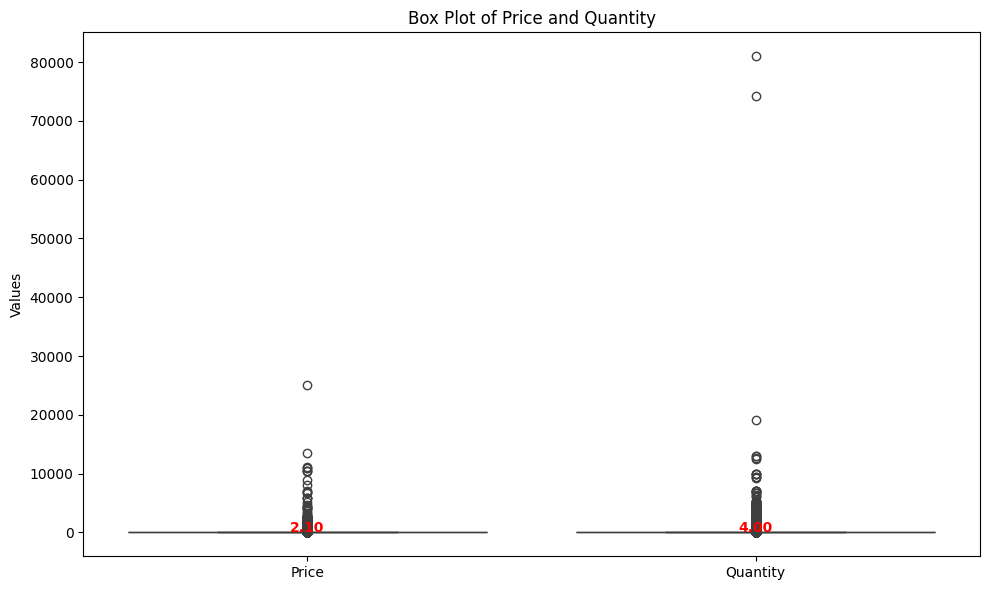

In [30]:
# box plots for Price and Quantity columns

df_pd = df.to_pandas()
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_pd[['Price', 'Quantity']])
medians = df_pd[['Price', 'Quantity']].median()
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.2f}', horizontalalignment='center', color='red', weight='bold')

plt.title('Box Plot of Price and Quantity')
plt.ylabel('Values')
plt.xticks([0, 1], ['Price', 'Quantity'])

plt.tight_layout()
plt.show()

In [31]:
def spot_outliers_iqr(df, column):
    '''
    Pass in dataframe and column
    return outliers in column, based on IQR
    '''
    q1 = df.select(pl.col(column).quantile(0.25)).item()
    q3 = df.select(pl.col(column).quantile(0.75)).item()
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers = df.filter((pl.col(column) < lower_bound) | (pl.col(column) > upper_bound))
    return outliers

quantity_outliers = spot_outliers_iqr(df, "Quantity")

price_outliers = spot_outliers_iqr(df, "Price")

print("Quantity Outliers:")
print(quantity_outliers)

print("\nPrice Outliers:")
print(price_outliers)

Quantity Outliers:
shape: (53_061, 8)
┌─────────┬───────────┬────────────────┬──────────┬────────────────┬───────┬─────────────┬─────────┐
│ Invoice ┆ StockCode ┆ Description    ┆ Quantity ┆ InvoiceDate    ┆ Price ┆ Customer ID ┆ Country │
│ ---     ┆ ---       ┆ ---            ┆ ---      ┆ ---            ┆ ---   ┆ ---         ┆ ---     │
│ str     ┆ str       ┆ str            ┆ i64      ┆ datetime[ns]   ┆ f64   ┆ f64         ┆ str     │
╞═════════╪═══════════╪════════════════╪══════════╪════════════════╪═══════╪═════════════╪═════════╡
│ 562439  ┆ 22561     ┆ WOODEN SCHOOL  ┆ 360      ┆ 2011-08-04     ┆ 1.45  ┆ 12931.0     ┆ United  │
│         ┆           ┆ COLOURING SET  ┆          ┆ 18:06:00       ┆       ┆             ┆ Kingdom │
│ 514696  ┆ 51020B    ┆ STRIPY DESIGN  ┆ 48       ┆ 2010-07-05     ┆ 0.29  ┆ 14900.0     ┆ United  │
│         ┆           ┆ SHOWER CAP     ┆          ┆ 15:09:00       ┆       ┆             ┆ Kingdom │
│ 516335  ┆ 72038P    ┆ PRICE'S CANDLE ┆ 50       ┆ 2

In [32]:
q1_price = df.select(pl.col("Price").quantile(0.25)).item()
q3_price = df.select(pl.col("Price").quantile(0.75)).item()
iqr_price = q3_price - q1_price

lower_bound_price = q1_price - 1.5 * iqr_price
upper_bound_price = q3_price + 1.5 * iqr_price

df = df.with_columns(
    ((pl.col("Price") < lower_bound_price) |
     (pl.col("Price") > upper_bound_price)).alias("Price_Outlier")
)

print(df)

shape: (1_007_914, 9)
┌─────────┬───────────┬──────────────┬──────────┬───┬───────┬──────────────┬─────────┬─────────────┐
│ Invoice ┆ StockCode ┆ Description  ┆ Quantity ┆ … ┆ Price ┆ Customer ID  ┆ Country ┆ Price_Outli │
│ ---     ┆ ---       ┆ ---          ┆ ---      ┆   ┆ ---   ┆ ---          ┆ ---     ┆ er          │
│ str     ┆ str       ┆ str          ┆ i64      ┆   ┆ f64   ┆ f64          ┆ str     ┆ ---         │
│         ┆           ┆              ┆          ┆   ┆       ┆              ┆         ┆ bool        │
╞═════════╪═══════════╪══════════════╪══════════╪═══╪═══════╪══════════════╪═════════╪═════════════╡
│ 526089  ┆ 22606     ┆ WOODEN       ┆ 1        ┆ … ┆ 15.95 ┆ 15281.0      ┆ United  ┆ true        │
│         ┆           ┆ SKITTLES     ┆          ┆   ┆       ┆              ┆ Kingdom ┆             │
│         ┆           ┆ GARDEN SET   ┆          ┆   ┆       ┆              ┆         ┆             │
│ 547652  ┆ 84970L    ┆ SINGLE HEART ┆ 24       ┆ … ┆ 0.95  ┆ 14606.0

In [33]:
# For team: See IQR for my logic 
q1_quantity = df.select(pl.col("Quantity").quantile(0.25)).item() 
q3_quantity = df.select(pl.col("Quantity").quantile(0.75)).item()
iqr_quantity = q3_quantity - q1_quantity

lower_bound_quantity = q1_quantity - 1.5 * iqr_quantity
upper_bound_quantity = q3_quantity + 1.5 * iqr_quantity

df = df.with_columns(
    ((pl.col("Quantity") < lower_bound_quantity) |
     (pl.col("Quantity") > upper_bound_quantity)).alias("Quantity_Outlier")
)

print(df)

# To remove quantity outliers (if desired)
# df_no_outliers = df.filter(~pl.col("Quantity_Outlier"))
# print(df_no_outliers)

shape: (1_007_914, 10)
┌─────────┬───────────┬────────────┬──────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ Invoice ┆ StockCode ┆ Descriptio ┆ Quantity ┆ … ┆ Customer   ┆ Country   ┆ Price_Out ┆ Quantity_ │
│ ---     ┆ ---       ┆ n          ┆ ---      ┆   ┆ ID         ┆ ---       ┆ lier      ┆ Outlier   │
│ str     ┆ str       ┆ ---        ┆ i64      ┆   ┆ ---        ┆ str       ┆ ---       ┆ ---       │
│         ┆           ┆ str        ┆          ┆   ┆ f64        ┆           ┆ bool      ┆ bool      │
╞═════════╪═══════════╪════════════╪══════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 526089  ┆ 22606     ┆ WOODEN     ┆ 1        ┆ … ┆ 15281.0    ┆ United    ┆ true      ┆ false     │
│         ┆           ┆ SKITTLES   ┆          ┆   ┆            ┆ Kingdom   ┆           ┆           │
│         ┆           ┆ GARDEN SET ┆          ┆   ┆            ┆           ┆           ┆           │
│ 547652  ┆ 84970L    ┆ SINGLE     ┆ 24       ┆ … ┆ 14606.0    ┆ Uni

### Symmetry Check

In [34]:
mean_price = df['Price'].mean()
median_price = df['Price'].median()

print(f"Mean price = {mean_price}")
print(f"Median price = {median_price}")

# Since mean = 4.2732 > median = 2.1, the price distribution is positively skewed (right-skewed).

# Comments:
# 1. Mean > median signals some significantly high prices (outliers) in the price col. 
# 2. Non symmetric distribution (positively/right skew)
# 3. Most prices are clustered around lower values, but there are a few very high prices.
# 4. Many transactions involve low-cost items, while a few involve high-cost items -> not uncommon in retail data 


Mean price = 4.074618457527131
Median price = 2.1


In [35]:
mean_quantity = df['Quantity'].mean()
median_quantity = df['Quantity'].median()

print(f"Mean quantity = {mean_quantity}")
print(f"Median quantity = {median_quantity}")

# Since mean = 11.521059840512516 > median = 3, the price distribution is positively skewed (right-skewed).

# Comments:
# 1. Mean > median signals some significantly high quantity (outliers) in the price col. 
# 2. Non symmetric distribution (positively/right skew)
# 3. Most quantity are clustered around lower values, but there are a few very high quantity.
# 4. Many transactions involve low quantity items, while a few involve high quantity items -> not uncommon in retail data 

Mean quantity = 11.117167734548781
Median quantity = 4.0


In [36]:
# Jason, if you can add a chart here showing symmetry, that would be better

In [37]:
def normalise_column(df, column):
    '''
    Input dataframe and column
    return min-max normalised column  
    '''
    col_min = df.select(pl.col(column).min()).item()
    col_max = df.select(pl.col(column).max()).item()
    normalised = (pl.col(column) - col_min) / (col_max - col_min)
    return normalised

# Why I used min-max scaling instead of z-score scaling:
# 1. Distribution is skewed (positive/right) and not symmetric
# 2. The distribution has outliers (min-max avoids changing the core shape of data distrib.)
# 3. Sensitive to feature scales (KNN, neural network, etc)
# 

numeric_columns = ["Quantity", "Price"]

df = df.with_columns([
    normalise_column(df, col).alias(f"{col}_Normalised") for col in numeric_columns
])

df

Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Price_Outlier,Quantity_Outlier,Quantity_Normalised,Price_Normalised
str,str,str,i64,datetime[ns],f64,f64,str,bool,bool,f64,f64
"""526089""","""22606""","""WOODEN SKITTLES GARDEN SET""",1,2010-10-08 12:14:00,15.95,15281.0,"""United Kingdom""",true,false,0.0,0.000635
"""547652""","""84970L""","""SINGLE HEART ZINC T-LIGHT HOLD…",24,2011-03-24 12:15:00,0.95,14606.0,"""United Kingdom""",false,false,0.000284,0.000038
"""534378""","""22065""","""CHRISTMAS PUDDING TRINKET POT """,6,2010-11-22 12:33:00,1.45,14461.0,"""United Kingdom""",false,false,0.000062,0.000058
"""545150""","""21523""","""DOORMAT FANCY FONT HOME SWEET …",2,2011-02-28 12:27:00,7.95,14227.0,"""United Kingdom""",false,false,0.000012,0.000317
"""524952""","""22595""","""CHRISTMAS GINGHAM HEART""",6,2010-10-01 13:09:00,0.85,null,"""United Kingdom""",false,false,0.000062,0.000034
…,…,…,…,…,…,…,…,…,…,…,…
"""492953""","""51012C""","""FEATHER DUSTER, COAL BLACK""",12,2009-12-21 15:20:00,1.25,14505.0,"""United Kingdom""",false,false,0.000136,0.00005
"""491966""","""21364""","""PEACE SMALL WOOD LETTERS""",1,2009-12-14 17:16:00,13.87,null,"""United Kingdom""",true,false,0.0,0.000552
"""575117""","""23583""","""LUNCH BAG PAISLEY PARK """,1,2011-11-08 14:22:00,1.65,12748.0,"""United Kingdom""",false,false,0.0,0.000066


# Feature Engineering

## Transaction Features

In [38]:
# add Revenue col 
df = df.with_columns((df['Quantity'] * df['Price']).alias('Revenue'))
df 


Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Price_Outlier,Quantity_Outlier,Quantity_Normalised,Price_Normalised,Revenue
str,str,str,i64,datetime[ns],f64,f64,str,bool,bool,f64,f64,f64
"""526089""","""22606""","""WOODEN SKITTLES GARDEN SET""",1,2010-10-08 12:14:00,15.95,15281.0,"""United Kingdom""",true,false,0.0,0.000635,15.95
"""547652""","""84970L""","""SINGLE HEART ZINC T-LIGHT HOLD…",24,2011-03-24 12:15:00,0.95,14606.0,"""United Kingdom""",false,false,0.000284,0.000038,22.8
"""534378""","""22065""","""CHRISTMAS PUDDING TRINKET POT """,6,2010-11-22 12:33:00,1.45,14461.0,"""United Kingdom""",false,false,0.000062,0.000058,8.7
"""545150""","""21523""","""DOORMAT FANCY FONT HOME SWEET …",2,2011-02-28 12:27:00,7.95,14227.0,"""United Kingdom""",false,false,0.000012,0.000317,15.9
"""524952""","""22595""","""CHRISTMAS GINGHAM HEART""",6,2010-10-01 13:09:00,0.85,null,"""United Kingdom""",false,false,0.000062,0.000034,5.1
…,…,…,…,…,…,…,…,…,…,…,…,…
"""492953""","""51012C""","""FEATHER DUSTER, COAL BLACK""",12,2009-12-21 15:20:00,1.25,14505.0,"""United Kingdom""",false,false,0.000136,0.00005,15.0
"""491966""","""21364""","""PEACE SMALL WOOD LETTERS""",1,2009-12-14 17:16:00,13.87,null,"""United Kingdom""",true,false,0.0,0.000552,13.87
"""575117""","""23583""","""LUNCH BAG PAISLEY PARK """,1,2011-11-08 14:22:00,1.65,12748.0,"""United Kingdom""",false,false,0.0,0.000066,1.65


## Time Based Features

In [39]:
# Extract Year, Month, Day, and Hour cols from InvoiceDate col 
df = df.with_columns([
    df["InvoiceDate"].dt.year().alias("Year"),
    df["InvoiceDate"].dt.month().alias("Month"),
    df["InvoiceDate"].dt.day().alias("Day"),
    df["InvoiceDate"].dt.hour().alias("Hour"),
])

df 

Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Price_Outlier,Quantity_Outlier,Quantity_Normalised,Price_Normalised,Revenue,Year,Month,Day,Hour
str,str,str,i64,datetime[ns],f64,f64,str,bool,bool,f64,f64,f64,i32,i8,i8,i8
"""526089""","""22606""","""WOODEN SKITTLES GARDEN SET""",1,2010-10-08 12:14:00,15.95,15281.0,"""United Kingdom""",true,false,0.0,0.000635,15.95,2010,10,8,12
"""547652""","""84970L""","""SINGLE HEART ZINC T-LIGHT HOLD…",24,2011-03-24 12:15:00,0.95,14606.0,"""United Kingdom""",false,false,0.000284,0.000038,22.8,2011,3,24,12
"""534378""","""22065""","""CHRISTMAS PUDDING TRINKET POT """,6,2010-11-22 12:33:00,1.45,14461.0,"""United Kingdom""",false,false,0.000062,0.000058,8.7,2010,11,22,12
"""545150""","""21523""","""DOORMAT FANCY FONT HOME SWEET …",2,2011-02-28 12:27:00,7.95,14227.0,"""United Kingdom""",false,false,0.000012,0.000317,15.9,2011,2,28,12
"""524952""","""22595""","""CHRISTMAS GINGHAM HEART""",6,2010-10-01 13:09:00,0.85,null,"""United Kingdom""",false,false,0.000062,0.000034,5.1,2010,10,1,13
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""492953""","""51012C""","""FEATHER DUSTER, COAL BLACK""",12,2009-12-21 15:20:00,1.25,14505.0,"""United Kingdom""",false,false,0.000136,0.00005,15.0,2009,12,21,15
"""491966""","""21364""","""PEACE SMALL WOOD LETTERS""",1,2009-12-14 17:16:00,13.87,null,"""United Kingdom""",true,false,0.0,0.000552,13.87,2009,12,14,17
"""575117""","""23583""","""LUNCH BAG PAISLEY PARK """,1,2011-11-08 14:22:00,1.65,12748.0,"""United Kingdom""",false,false,0.0,0.000066,1.65,2011,11,8,14


In [40]:
# create cols for day of the week, whether weekend or not (in case more shopping can be done on weekends)
df = df.with_columns([
    pl.col("InvoiceDate").dt.weekday().alias("Day Of Week"),  # 1 - Monday, 2 - Tuesday, ..., 7 - Sunday
    (pl.col("InvoiceDate").dt.weekday() >= 5).alias("IsWeekend")  
])

df

Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Price_Outlier,Quantity_Outlier,Quantity_Normalised,Price_Normalised,Revenue,Year,Month,Day,Hour,Day Of Week,IsWeekend
str,str,str,i64,datetime[ns],f64,f64,str,bool,bool,f64,f64,f64,i32,i8,i8,i8,i8,bool
"""526089""","""22606""","""WOODEN SKITTLES GARDEN SET""",1,2010-10-08 12:14:00,15.95,15281.0,"""United Kingdom""",true,false,0.0,0.000635,15.95,2010,10,8,12,5,true
"""547652""","""84970L""","""SINGLE HEART ZINC T-LIGHT HOLD…",24,2011-03-24 12:15:00,0.95,14606.0,"""United Kingdom""",false,false,0.000284,0.000038,22.8,2011,3,24,12,4,false
"""534378""","""22065""","""CHRISTMAS PUDDING TRINKET POT """,6,2010-11-22 12:33:00,1.45,14461.0,"""United Kingdom""",false,false,0.000062,0.000058,8.7,2010,11,22,12,1,false
"""545150""","""21523""","""DOORMAT FANCY FONT HOME SWEET …",2,2011-02-28 12:27:00,7.95,14227.0,"""United Kingdom""",false,false,0.000012,0.000317,15.9,2011,2,28,12,1,false
"""524952""","""22595""","""CHRISTMAS GINGHAM HEART""",6,2010-10-01 13:09:00,0.85,null,"""United Kingdom""",false,false,0.000062,0.000034,5.1,2010,10,1,13,5,true
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""492953""","""51012C""","""FEATHER DUSTER, COAL BLACK""",12,2009-12-21 15:20:00,1.25,14505.0,"""United Kingdom""",false,false,0.000136,0.00005,15.0,2009,12,21,15,1,false
"""491966""","""21364""","""PEACE SMALL WOOD LETTERS""",1,2009-12-14 17:16:00,13.87,null,"""United Kingdom""",true,false,0.0,0.000552,13.87,2009,12,14,17,1,false
"""575117""","""23583""","""LUNCH BAG PAISLEY PARK """,1,2011-11-08 14:22:00,1.65,12748.0,"""United Kingdom""",false,false,0.0,0.000066,1.65,2011,11,8,14,2,false


## Country/Geographic Based Features

In [41]:
df['Country'].unique().count()

# there are 43 unique countries. Have to use either label encoding or target encoding. 

43

In [42]:
# Encode Country col (Label Encoding)
le = LabelEncoder()
encoded_values = le.fit_transform(df['Country'].to_numpy())

# Add encoded column to the df 
df = df.with_columns(pl.Series('Country_encoded', encoded_values))



df 

Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Price_Outlier,Quantity_Outlier,Quantity_Normalised,Price_Normalised,Revenue,Year,Month,Day,Hour,Day Of Week,IsWeekend,Country_encoded
str,str,str,i64,datetime[ns],f64,f64,str,bool,bool,f64,f64,f64,i32,i8,i8,i8,i8,bool,i64
"""526089""","""22606""","""WOODEN SKITTLES GARDEN SET""",1,2010-10-08 12:14:00,15.95,15281.0,"""United Kingdom""",true,false,0.0,0.000635,15.95,2010,10,8,12,5,true,40
"""547652""","""84970L""","""SINGLE HEART ZINC T-LIGHT HOLD…",24,2011-03-24 12:15:00,0.95,14606.0,"""United Kingdom""",false,false,0.000284,0.000038,22.8,2011,3,24,12,4,false,40
"""534378""","""22065""","""CHRISTMAS PUDDING TRINKET POT """,6,2010-11-22 12:33:00,1.45,14461.0,"""United Kingdom""",false,false,0.000062,0.000058,8.7,2010,11,22,12,1,false,40
"""545150""","""21523""","""DOORMAT FANCY FONT HOME SWEET …",2,2011-02-28 12:27:00,7.95,14227.0,"""United Kingdom""",false,false,0.000012,0.000317,15.9,2011,2,28,12,1,false,40
"""524952""","""22595""","""CHRISTMAS GINGHAM HEART""",6,2010-10-01 13:09:00,0.85,null,"""United Kingdom""",false,false,0.000062,0.000034,5.1,2010,10,1,13,5,true,40
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""492953""","""51012C""","""FEATHER DUSTER, COAL BLACK""",12,2009-12-21 15:20:00,1.25,14505.0,"""United Kingdom""",false,false,0.000136,0.00005,15.0,2009,12,21,15,1,false,40
"""491966""","""21364""","""PEACE SMALL WOOD LETTERS""",1,2009-12-14 17:16:00,13.87,null,"""United Kingdom""",true,false,0.0,0.000552,13.87,2009,12,14,17,1,false,40
"""575117""","""23583""","""LUNCH BAG PAISLEY PARK """,1,2011-11-08 14:22:00,1.65,12748.0,"""United Kingdom""",false,false,0.0,0.000066,1.65,2011,11,8,14,2,false,40


In [43]:
# Country encoding is done in alphabetical order \
df[['Country', 'Country_encoded']].unique().sort(by = 'Country_encoded')

Country,Country_encoded
str,i64
"""Australia""",0
"""Austria""",1
"""Bahrain""",2
"""Belgium""",3
"""Bermuda""",4
…,…
"""USA""",38
"""United Arab Emirates""",39
"""United Kingdom""",40


In [44]:
# investigating the null customer id, combined having the top total revenue:
df.filter(
    pl.col('Customer ID').is_null()
)

# This could mean customers without membership, system issue, etc. Propose to business etc 

Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Price_Outlier,Quantity_Outlier,Quantity_Normalised,Price_Normalised,Revenue,Year,Month,Day,Hour,Day Of Week,IsWeekend,Country_encoded
str,str,str,i64,datetime[ns],f64,f64,str,bool,bool,f64,f64,f64,i32,i8,i8,i8,i8,bool,i64
"""524952""","""22595""","""CHRISTMAS GINGHAM HEART""",6,2010-10-01 13:09:00,0.85,null,"""United Kingdom""",false,false,0.000062,0.000034,5.1,2010,10,1,13,5,true,40
"""532063""","""22815""","""CARD PSYCHEDELIC APPLES""",4,2010-11-10 14:48:00,0.85,null,"""United Kingdom""",false,false,0.000037,0.000034,3.4,2010,11,10,14,3,false,40
"""537823""","""21067""","""VINTAGE RED TEATIME MUG""",1,2010-12-08 14:25:00,2.51,null,"""United Kingdom""",false,false,0.0,0.0001,2.51,2010,12,8,14,3,false,40
"""540995""","""21928""","""JUMBO BAG SCANDINAVIAN PAISLEY""",2,2011-01-13 09:30:00,4.13,null,"""United Kingdom""",false,false,0.000012,0.000164,8.26,2011,1,13,9,4,false,40
"""541871""","""21232""","""STRAWBERRY CERAMIC TRINKET BOX""",2,2011-01-24 09:41:00,2.46,null,"""United Kingdom""",false,false,0.000012,0.000098,4.92,2011,1,24,9,1,false,40
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""569202""","""21174""","""POTTERING IN THE SHED METAL SI…",2,2011-09-30 17:22:00,4.13,null,"""United Kingdom""",false,false,0.000012,0.000164,8.26,2011,9,30,17,5,true,40
"""545717""","""22161""","""HEART DECORATION RUSTIC HANGIN…",1,2011-03-07 10:15:00,1.63,null,"""United Kingdom""",false,false,0.0,0.000065,1.63,2011,3,7,10,1,false,40
"""556080""","""22730""","""ALARM CLOCK BAKELIKE IVORY""",1,2011-06-08 15:21:00,8.29,null,"""United Kingdom""",false,false,0.0,0.00033,8.29,2011,6,8,15,3,false,40


In [45]:
# create col to classify whether transaction was domestic or not. 
# removes spaces before and after "united kingdom" 
# captures "united kingdom" regardless of upper or lower case 
df = df.with_columns(
    (pl.col("Country").str.strip_chars().str.to_lowercase() == "united kingdom").alias("Is Domestic")
)

df 

Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Price_Outlier,Quantity_Outlier,Quantity_Normalised,Price_Normalised,Revenue,Year,Month,Day,Hour,Day Of Week,IsWeekend,Country_encoded,Is Domestic
str,str,str,i64,datetime[ns],f64,f64,str,bool,bool,f64,f64,f64,i32,i8,i8,i8,i8,bool,i64,bool
"""526089""","""22606""","""WOODEN SKITTLES GARDEN SET""",1,2010-10-08 12:14:00,15.95,15281.0,"""United Kingdom""",true,false,0.0,0.000635,15.95,2010,10,8,12,5,true,40,true
"""547652""","""84970L""","""SINGLE HEART ZINC T-LIGHT HOLD…",24,2011-03-24 12:15:00,0.95,14606.0,"""United Kingdom""",false,false,0.000284,0.000038,22.8,2011,3,24,12,4,false,40,true
"""534378""","""22065""","""CHRISTMAS PUDDING TRINKET POT """,6,2010-11-22 12:33:00,1.45,14461.0,"""United Kingdom""",false,false,0.000062,0.000058,8.7,2010,11,22,12,1,false,40,true
"""545150""","""21523""","""DOORMAT FANCY FONT HOME SWEET …",2,2011-02-28 12:27:00,7.95,14227.0,"""United Kingdom""",false,false,0.000012,0.000317,15.9,2011,2,28,12,1,false,40,true
"""524952""","""22595""","""CHRISTMAS GINGHAM HEART""",6,2010-10-01 13:09:00,0.85,null,"""United Kingdom""",false,false,0.000062,0.000034,5.1,2010,10,1,13,5,true,40,true
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""492953""","""51012C""","""FEATHER DUSTER, COAL BLACK""",12,2009-12-21 15:20:00,1.25,14505.0,"""United Kingdom""",false,false,0.000136,0.00005,15.0,2009,12,21,15,1,false,40,true
"""491966""","""21364""","""PEACE SMALL WOOD LETTERS""",1,2009-12-14 17:16:00,13.87,null,"""United Kingdom""",true,false,0.0,0.000552,13.87,2009,12,14,17,1,false,40,true
"""575117""","""23583""","""LUNCH BAG PAISLEY PARK """,1,2011-11-08 14:22:00,1.65,12748.0,"""United Kingdom""",false,false,0.0,0.000066,1.65,2011,11,8,14,2,false,40,true


In [46]:
# make chart on domestic vs not

## Description Column Features

In [47]:
# # Extract keywords from Description
# df = df.with_columns(
#     pl.col("Description").str.extract(r"(\w+)", 1).alias("First Keyword")
# )

# df 

In [48]:
# # # Get keyword using TF-IDF (Term Frequency-Inverse Document Frequency)
# df_pandas = df.to_pandas()

# # First, set up TF-IDF Vectorizer
# vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)  # Parameters: remove English stopwords and limit vocab 
# tfidf_matrix = vectorizer.fit_transform(df_pandas["Description"].fillna(""))  # Fill nulls with empty strings (just in case) - a redundancy since I already filled nulls previously in description

# # Obtain feature names (words) and corresponding TF-IDF scores
# feature_names = vectorizer.get_feature_names_out()
# tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# # Extract the highest-scoring word (keyword) for each row
# df_pandas["Keyword"] = tfidf_df.idxmax(axis=1)

# # Convert back to Polars DataFrame
# df = pl.from_pandas(df_pandas)

# # df 

In [49]:
# # Try Pretrained model (e.g. BERT) or KMeans or DBScan instead of TF-IDF.

# # Must include categories: Engine, Tyre, Key, Glass, Computer, Chair, as required in Q8... other categories (check which is best) Other 



# # Load a text classification pipeline (requires a labeled dataset or pre-trained categories)
# classifier = pipeline("zero-shot-classification")

# # Define potential categories
# candidate_labels = ['Engine', 'Tyre', 'Key', 'Glass', 'Computer', 'Chair', 'Other'] 
# # 'Electronics', 'Fashion', 'Food', 'Beverage', 'DIY', 'Furniture', 'Media', 'Beauty', 'Toy']

# # Predict categories 
# df = df.with_columns(
#     pl.col("Description").map_elements(
#         lambda desc: classifier(desc, candidate_labels)["labels"][0]
#     ).alias("Category")
# )

# df 


In [50]:
# keywords = ["Engine", "Tyre", "Key", "Glass", "Computer", "Chair"]

# df = df.with_columns(
#     pl.col("Description")
#     .map_elements(
#         lambda desc: next(
#             (kw for kw in keywords if kw.lower() in desc.lower()), "Other"
#         )
#     )
#     .alias("keyword")
# )

# keyword_counts = df.group_by("keyword").agg(pl.count("keyword").alias("count"))

# df

In [51]:
# keyword_counts

## Summaries and Aggregations

In [52]:
# Customer-level aggregation, sorted by total revenue from highest to lowest
customer_summary = df.group_by("Customer ID").agg([
    pl.sum("Revenue").alias("Total Revenue"),
    # pl.n_unique("Invoice").alias("Num of Invoices"),
    pl.sum("Quantity").alias("Total Quantity"),
]).sort(by='Total Revenue', descending = True)

customer_summary



Customer ID,Total Revenue,Total Quantity
f64,f64,i64
null,3.1018e6,691197
18102.0,580987.04,181645
14646.0,528602.52,367193
14156.0,313437.62,164325
14911.0,291420.81,147972
…,…,…
15913.0,6.3,3
14792.0,6.2,2
16738.0,3.75,3


/var/folders/pl/vldk2f117ps7jbp86h049rxc0000gn/T/ipykernel_24474/893487627.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


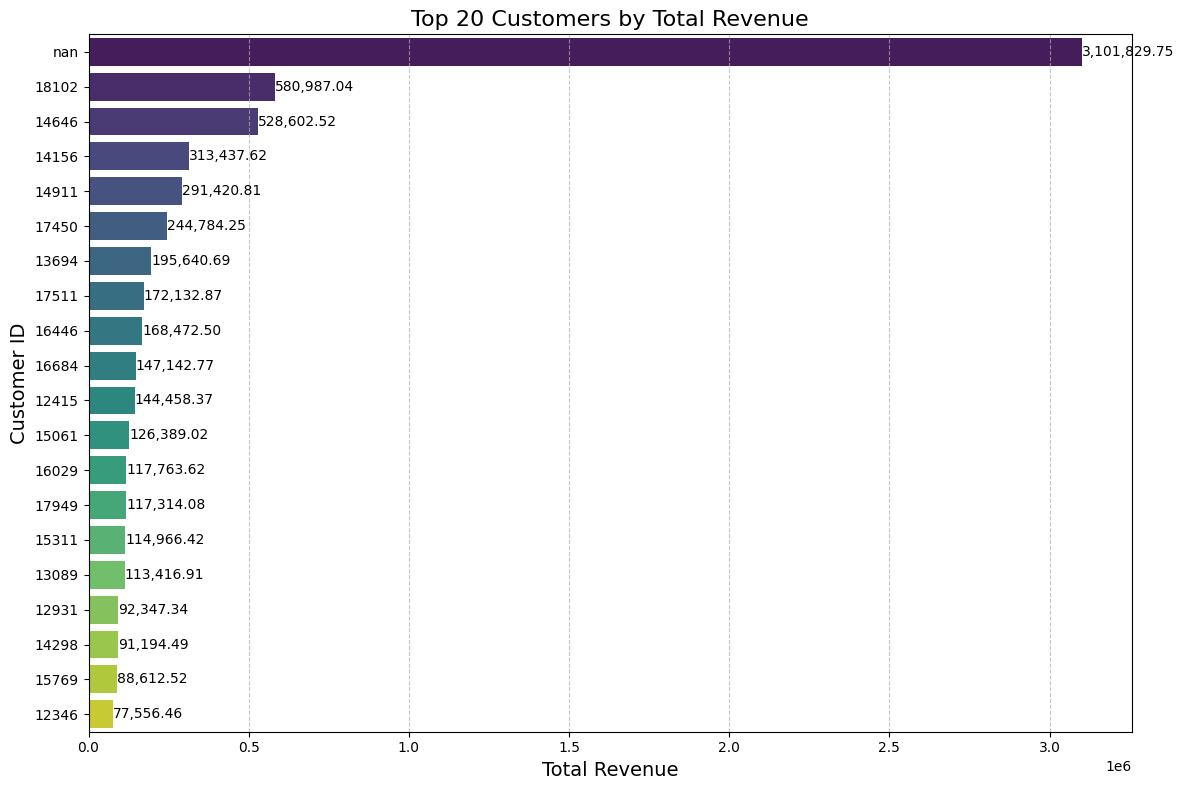

In [53]:
# Plot the top 20 customers (using customer id), sorted by total revenue, from highest to lowest. 
top_n = 20
customer_summary_top = customer_summary.head(top_n).to_pandas()

customer_summary_top["Customer ID"] = (
    customer_summary_top["Customer ID"]
    .astype(str)
    .str.replace(r'\.0$', '', regex=True)
    .str[:10]  
)

plt.figure(figsize=(12, 8))  
sns.barplot(
    data=customer_summary_top,
    y="Customer ID",
    x="Total Revenue",
    palette="viridis"
)

for index, value in enumerate(customer_summary_top["Total Revenue"]):
    plt.text(value, index, f'{value:,.2f}', va='center')

plt.title(f"Top {top_n} Customers by Total Revenue", fontsize=16)
plt.xlabel("Total Revenue", fontsize=14)
plt.ylabel("Customer ID", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


# As seen on chart, top customer ID are nulls/NaN. Meaning the company has not tagged their customer ID. Does this mean they are not members of the company? Not registered? We can tell company that on aggregate, there's a significant amount of people showing who are not tagged. 

In [54]:
# count number of null customers and average revenue

df.select([
    pl.col('Customer ID').is_null().sum().alias('customer id null count'),
    pl.col('Revenue').mean().alias('avg revenue per customer without id'),
    pl.col('Revenue').median().alias('median revenue per customer without id'),
    pl.col('Revenue').mode().alias('mode revenue per customer without id'),
    pl.col('Revenue').max().alias('max revenue per customer without id'),
    pl.col('Revenue').min().alias('min revenue per customer without id'),

])

# This helps us understand the nature of the customers with no customer ID. See their revenue per customer avg, mean, median, mode, max, min

customer id null count,avg revenue per customer without id,median revenue per customer without id,mode revenue per customer without id,max revenue per customer without id,min revenue per customer without id
u32,f64,f64,f64,f64,f64
228489,20.315854,10.08,15.0,168469.6,0.001


In [55]:
# create df to calculate info on total revenue, avg order value, and total quantity PER customer. Sort by Total Revenue from highest to lowest

customer_metrics = df.group_by("Customer ID").agg([
    pl.sum("Revenue").alias("Total Revenue"),
    pl.mean("Revenue").alias("Avg Order Value"),
    pl.sum("Quantity").alias("Total Quantity")
]).sort(by='Total Revenue', descending=True)

customer_metrics
# null customer ID has the highest (could be multiple customers or customers not tagged with our IDs (e.g., not a member)). 

Customer ID,Total Revenue,Avg Order Value,Total Quantity
f64,f64,f64,i64
null,3.1018e6,13.575401,691197
18102.0,580987.04,558.641385,181645
14646.0,528602.52,137.335027,367193
14156.0,313437.62,77.621996,164325
14911.0,291420.81,26.30864,147972
…,…,…,…
15913.0,6.3,6.3,3
14792.0,6.2,3.1,2
16738.0,3.75,3.75,3


In [56]:
# Country level summary, sorted by total revenue
country_summary = df.group_by('Country_encoded').agg([
    pl.col('Country'),
    pl.n_unique('Invoice').alias('Num of Invoices'),
    pl.sum('Revenue').alias('Total Revenue'),
    pl.sum('Quantity').alias('Total Quantity')
]).sort(by='Total Revenue', descending=True)

country_summary
    


Country_encoded,Country,Num of Invoices,Total Revenue,Total Quantity
i64,list[str],u32,f64,i64
40,"[""United Kingdom"", ""United Kingdom"", … ""United Kingdom""]",36536,1.7411e7,9187754
11,"[""EIRE"", ""EIRE"", … ""EIRE""]",626,658767.31,336329
26,"[""Netherlands"", ""Netherlands"", … ""Netherlands""]",228,554038.09,383879
15,"[""Germany"", ""Germany"", … ""Germany""]",789,425019.711,225154
14,"[""France"", ""France"", … ""France""]",622,350456.09,271901
…,…,…,…,…
22,"[""Korea"", ""Korea"", … ""Korea""]",2,1118.51,700
9,"[""Czech Republic"", ""Czech Republic"", … ""Czech Republic""]",2,826.74,671
42,"[""West Indies"", ""West Indies"", … ""West Indies""]",1,536.41,395


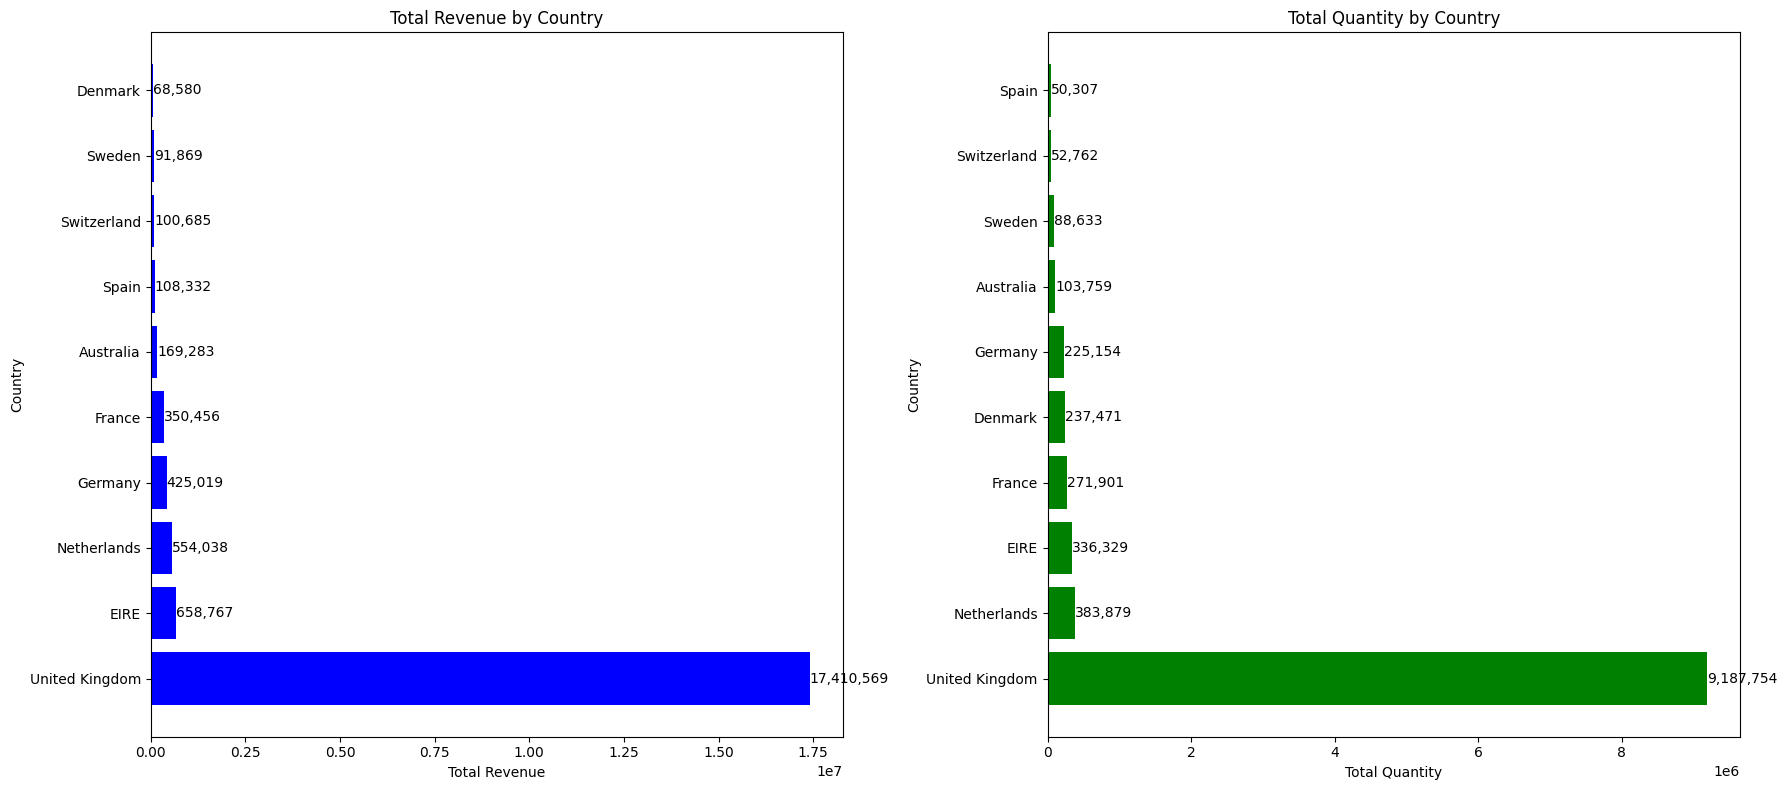

In [57]:
# Plot revenue and quantity per country

country_summary_pd = country_summary.to_pandas()
country_summary_top10 = country_summary_pd.sort_values(by='Total Revenue', ascending=False).head(10)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
country_summary_top10_revenue = country_summary_top10.sort_values(by='Total Revenue', ascending=False)

bars1 = axes[0].barh(country_summary_top10_revenue['Country'].apply(lambda x: x[0]), country_summary_top10_revenue['Total Revenue'], color='b')
axes[0].set_title('Total Revenue by Country')
axes[0].set_xlabel('Total Revenue')
axes[0].set_ylabel('Country')

country_summary_top10_quantity = country_summary_top10.sort_values(by='Total Quantity', ascending=False)

bars2 = axes[1].barh(country_summary_top10_quantity['Country'].apply(lambda x: x[0]), country_summary_top10_quantity['Total Quantity'], color='g')
axes[1].set_title('Total Quantity by Country')
axes[1].set_xlabel('Total Quantity')
axes[1].set_ylabel('Country')

def add_labels(bars, ax):
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height() / 2, f'{int(width):,}', va='center', ha='left')

add_labels(bars1, axes[0])
add_labels(bars2, axes[1])

plt.tight_layout()
plt.show()

# Top country is overwhelmingly the UK

/var/folders/pl/vldk2f117ps7jbp86h049rxc0000gn/T/ipykernel_24474/3016712317.py:3: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()


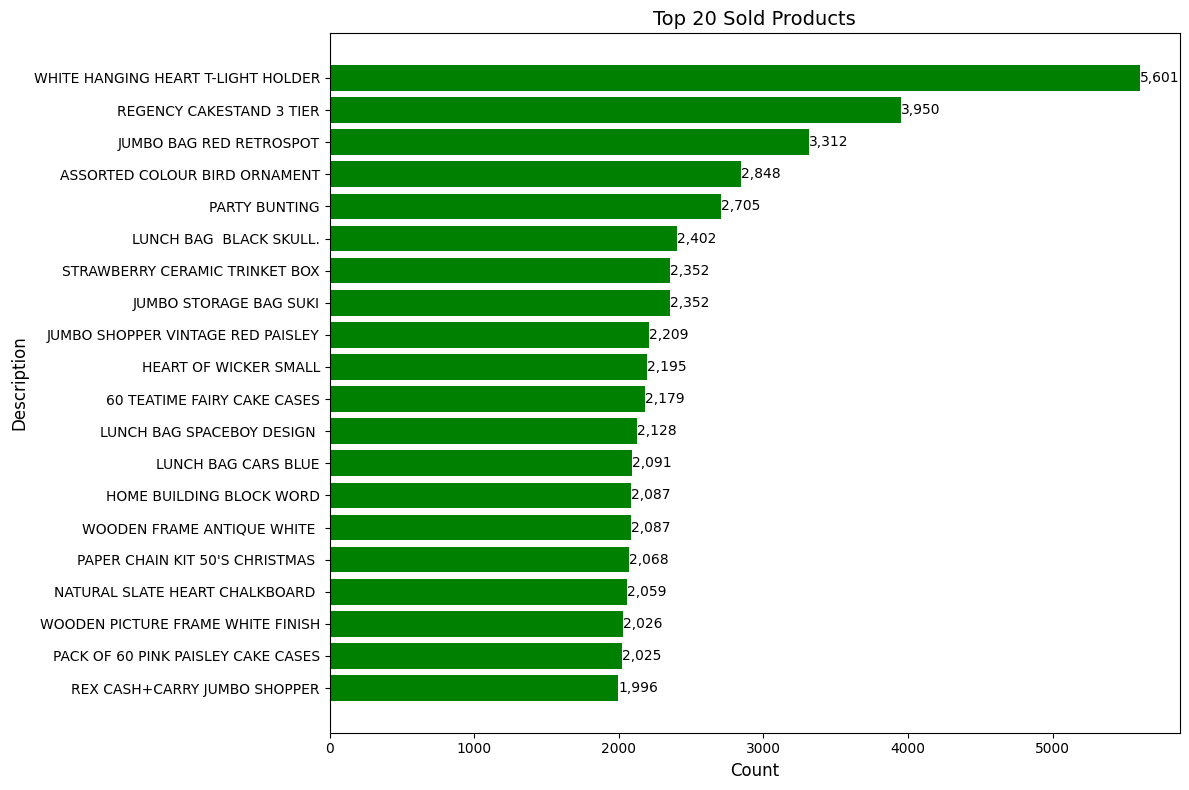

In [58]:
top_products_20 = (
    df.group_by("Description")
    .count()
    .sort("count", descending=True)
    .head(20)  
)

top_products_20 = top_products_20.to_pandas()

plt.figure(figsize=(12, 8))
bars = plt.barh(top_products_20["Description"], top_products_20["count"], color="green")
plt.xlabel("Count", fontsize=12)
plt.ylabel("Description", fontsize=12)
plt.title("Top 20 Sold Products", fontsize=14)
plt.gca().invert_yaxis() 
plt.tight_layout()

for bar in bars:
    plt.text(
        bar.get_width(),  
        bar.get_y() + bar.get_height() / 2,  
        f'{bar.get_width():,.0f}', 
        va='center', 
        ha='left',  
        fontsize=10
    )

plt.show()

In [59]:
# top_countries = (
#     df.group_by("Country")
#     .agg(pl.col("Revenue").sum().alias("TotalRevenue"))
#     .sort("TotalRevenue", descending=True)
#     .head(5)  
# )["Country"]

# filtered_df = df.filter(pl.col("Country").is_in(top_countries))

# top_products_by_country = (
#     filtered_df.group_by(["Country", "Description"])
#     .agg(pl.col("Revenue").sum().alias("TotalRevenue"))
#     .sort(["Country", "TotalRevenue"], descending=[False, True])  
#     .group_by("Country")
#     .head(5)  
# )

# plot_data = top_products_by_country.to_pandas()

# plt.figure(figsize=(14, 8))
# countries = plot_data["Country"].unique()
# x = np.arange(len(countries))  
# bar_width = 0.15  
# colors = plt.cm.tab10(np.linspace(0, 1, 5))  

# for i, product in enumerate(plot_data["Description"].unique()):  
#     product_data = plot_data[plot_data["Description"] == product]
#     country_indices = [
#         np.where(countries == country)[0][0] for country in product_data["Country"]
#     ]  
#     plt.bar(
#         x[country_indices] + i * bar_width,  
#         product_data["TotalRevenue"],
#         width=bar_width,
#         label=product,
#         color=colors[i % len(colors)],
#     )
    
#     for x_pos, y_pos in zip(
#         x[country_indices] + i * bar_width, product_data["TotalRevenue"]
#     ):
#         plt.text(
#             x_pos,
#             y_pos,
#             f"{y_pos:.1f}",
#             ha="center",
#             va="bottom",
#             fontsize=8,
#         )

# plt.xlabel("Country", fontsize=12)
# plt.ylabel("Total Revenue", fontsize=12)
# plt.title("Top 5 Products by Revenue for Top 5 Countries", fontsize=14)
# plt.xticks(x + bar_width * 2, countries, rotation=45, ha="right", fontsize=10)
# plt.legend(title="Product", fontsize=10)
# plt.tight_layout()
# plt.show()

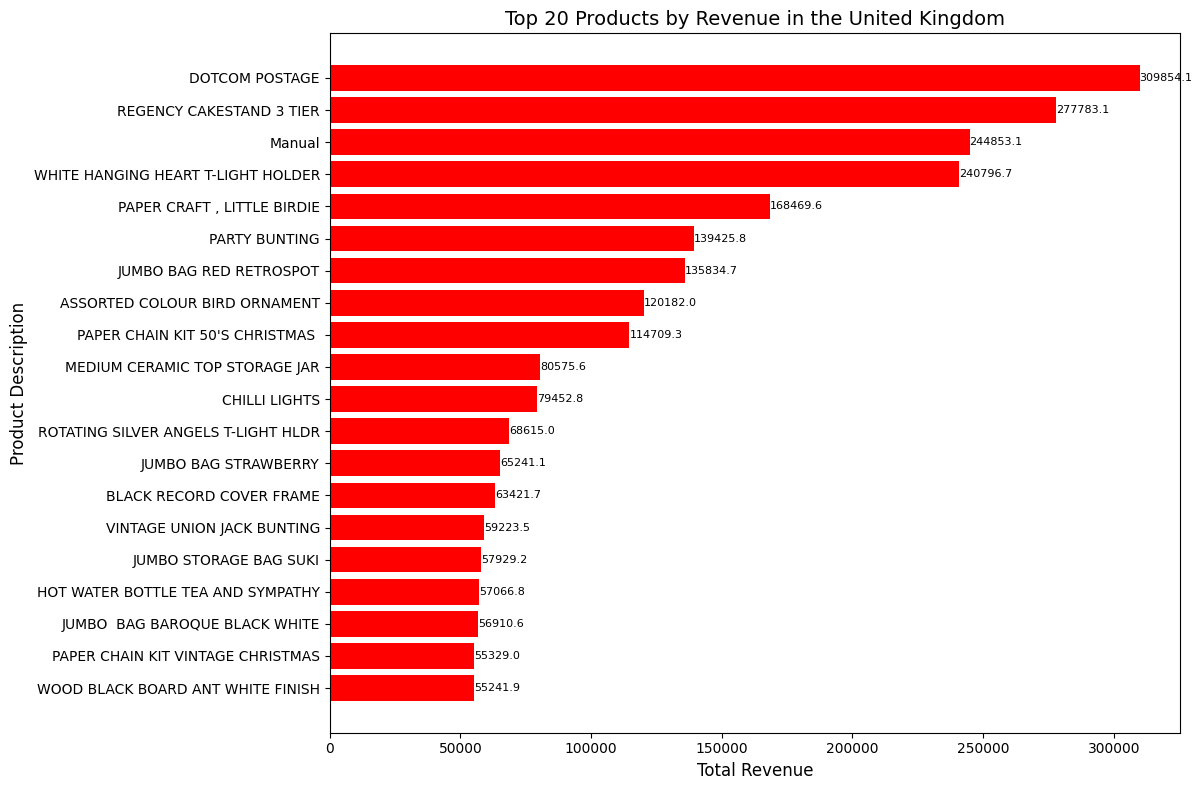

In [60]:
# Top products sold in the UK
uk_df = df.filter(pl.col("Country").str.to_lowercase() == "united kingdom")


top_products_uk = (
    uk_df.group_by("Description")
    .agg(pl.col("Revenue").sum().alias("TotalRevenue"))
    .sort("TotalRevenue", descending=True)  
    .head(20)  
)


plot_data = top_products_uk.to_pandas()


plt.figure(figsize=(12, 8))
plt.barh(plot_data["Description"], plot_data["TotalRevenue"], color="red")
plt.xlabel("Total Revenue", fontsize=12)
plt.ylabel("Product Description", fontsize=12)
plt.title("Top 20 Products by Revenue in the United Kingdom", fontsize=14)
plt.gca().invert_yaxis()  
plt.tight_layout()


for i, value in enumerate(plot_data["TotalRevenue"]):
    plt.text(value, i, f"{value:.1f}", va="center", fontsize=8)

plt.show()

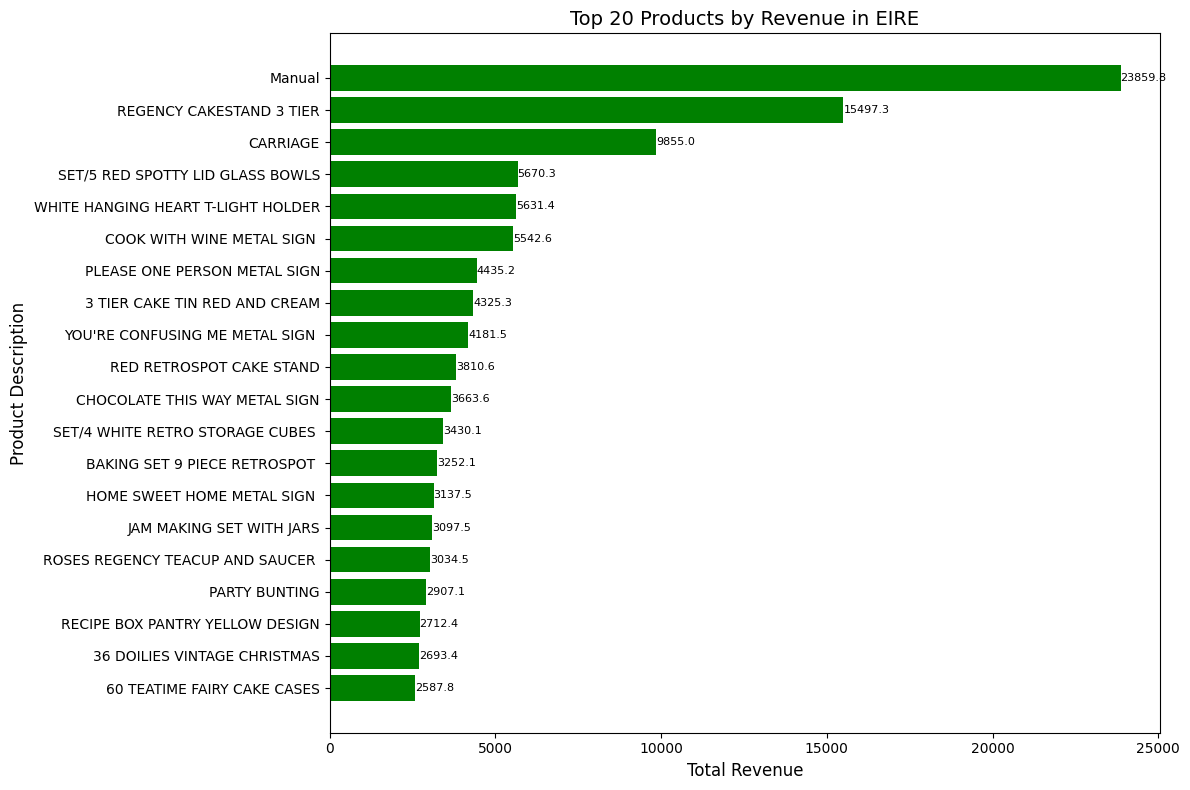

In [61]:
# Top products sold in the EIRE
eire_df = df.filter(pl.col("Country").str.to_lowercase() == "eire")


top_products_eire = (
    eire_df.group_by("Description")
    .agg(pl.col("Revenue").sum().alias("TotalRevenue"))
    .sort("TotalRevenue", descending=True)  
    .head(20)  
)


plot_data = top_products_eire.to_pandas()


plt.figure(figsize=(12, 8))
plt.barh(plot_data["Description"], plot_data["TotalRevenue"], color="green")
plt.xlabel("Total Revenue", fontsize=12)
plt.ylabel("Product Description", fontsize=12)
plt.title("Top 20 Products by Revenue in EIRE", fontsize=14)
plt.gca().invert_yaxis()  
plt.tight_layout()


for i, value in enumerate(plot_data["TotalRevenue"]):
    plt.text(value, i, f"{value:.1f}", va="center", fontsize=8)

plt.show()

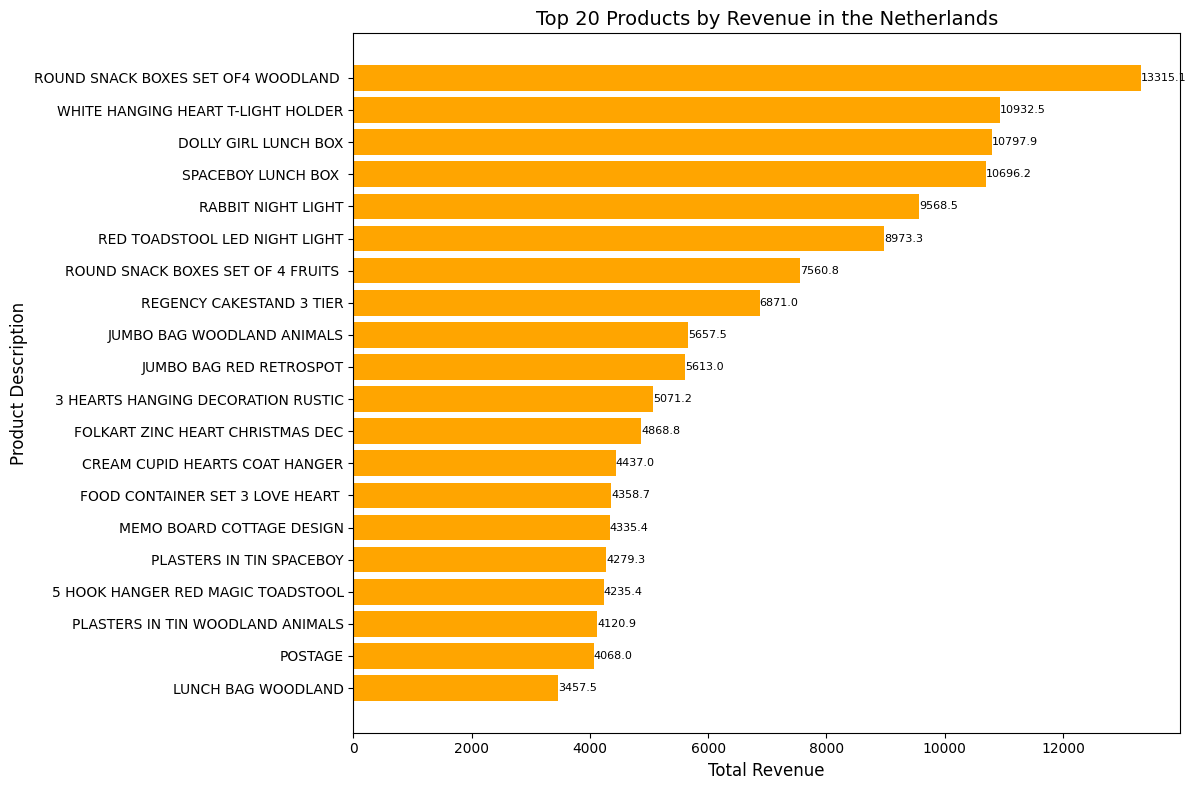

In [62]:
# Top products sold in the Netherlands
netherlands_df = df.filter(pl.col("Country").str.to_lowercase() == "netherlands")


top_products_netherlands = (
    netherlands_df.group_by("Description")
    .agg(pl.col("Revenue").sum().alias("TotalRevenue"))
    .sort("TotalRevenue", descending=True)  
    .head(20)  
)


plot_data = top_products_netherlands.to_pandas()


plt.figure(figsize=(12, 8))
plt.barh(plot_data["Description"], plot_data["TotalRevenue"], color="orange")
plt.xlabel("Total Revenue", fontsize=12)
plt.ylabel("Product Description", fontsize=12)
plt.title("Top 20 Products by Revenue in the Netherlands", fontsize=14)
plt.gca().invert_yaxis()  
plt.tight_layout()


for i, value in enumerate(plot_data["TotalRevenue"]):
    plt.text(value, i, f"{value:.1f}", va="center", fontsize=8)

plt.show()

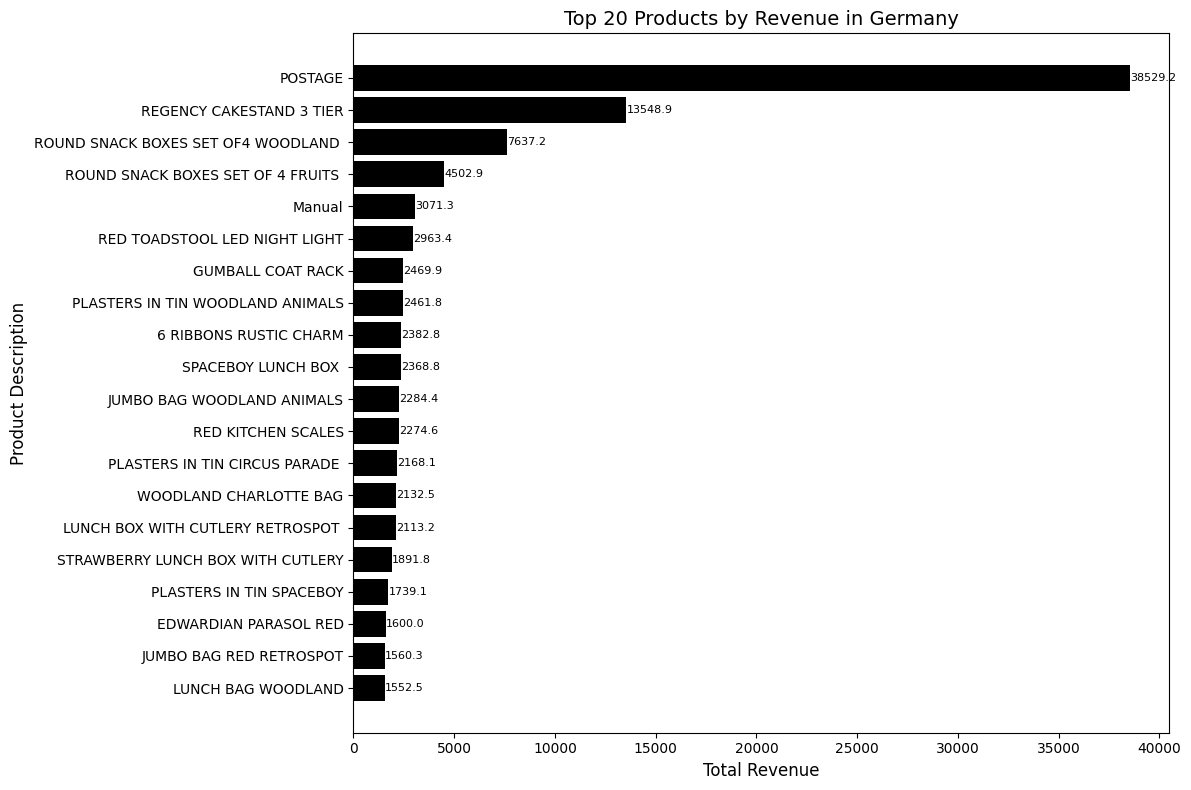

In [63]:
# Top products sold in Germany
germany_df = df.filter(pl.col("Country").str.to_lowercase() == "germany")


top_products_germany = (
    germany_df.group_by("Description")
    .agg(pl.col("Revenue").sum().alias("TotalRevenue"))
    .sort("TotalRevenue", descending=True)  
    .head(20)  
)


plot_data = top_products_germany.to_pandas()


plt.figure(figsize=(12, 8))
plt.barh(plot_data["Description"], plot_data["TotalRevenue"], color="black")
plt.xlabel("Total Revenue", fontsize=12)
plt.ylabel("Product Description", fontsize=12)
plt.title("Top 20 Products by Revenue in Germany", fontsize=14)
plt.gca().invert_yaxis()  
plt.tight_layout()


for i, value in enumerate(plot_data["TotalRevenue"]):
    plt.text(value, i, f"{value:.1f}", va="center", fontsize=8)

plt.show()

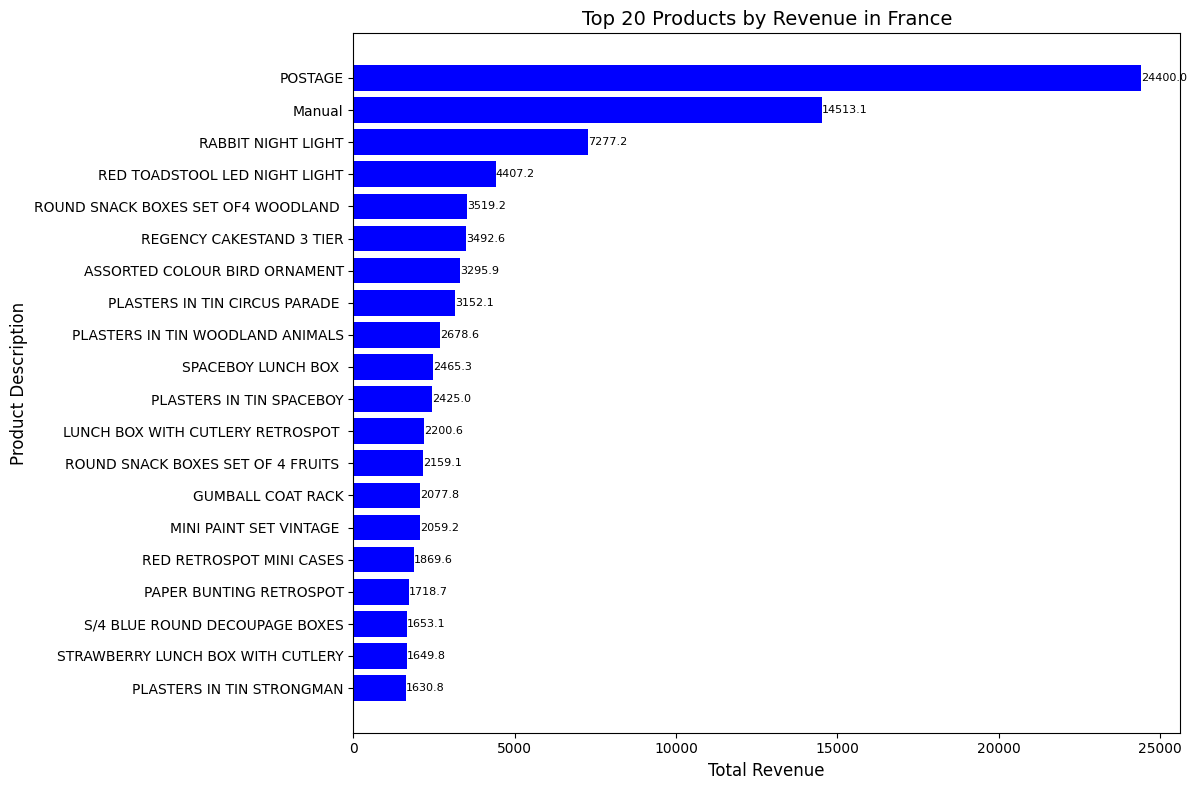

In [64]:
# Top products sold in France
france_df = df.filter(pl.col("Country").str.to_lowercase() == "france")


top_products_france = (
    france_df.group_by("Description")
    .agg(pl.col("Revenue").sum().alias("TotalRevenue"))
    .sort("TotalRevenue", descending=True)  
    .head(20)  
)


plot_data = top_products_france.to_pandas()


plt.figure(figsize=(12, 8))
plt.barh(plot_data["Description"], plot_data["TotalRevenue"], color="blue")
plt.xlabel("Total Revenue", fontsize=12)
plt.ylabel("Product Description", fontsize=12)
plt.title("Top 20 Products by Revenue in France", fontsize=14)
plt.gca().invert_yaxis()  
plt.tight_layout()


for i, value in enumerate(plot_data["TotalRevenue"]):
    plt.text(value, i, f"{value:.1f}", va="center", fontsize=8)

plt.show()

In [65]:

# summary per year, month, sort by year and month in descending order

monthly_summary = df.group_by('Year', 'Month').agg(
    pl.sum('Revenue').alias('Total Revenue'),
    pl.sum('Quantity').alias('Total Quantity')
).sort(by=['Year', 'Month'], descending=True)

monthly_summary

Year,Month,Total Revenue,Total Quantity
i32,i8,f64,i64
2011,12,637808.33,313613
2011,11,1.5039e6,751377
2011,10,1.1513e6,621029
2011,9,1.0564e6,569573
2011,8,757841.38,421020
…,…,…,…
2010,4,678875.252,366705
2010,3,830915.261,526026
2010,2,551878.296,381880


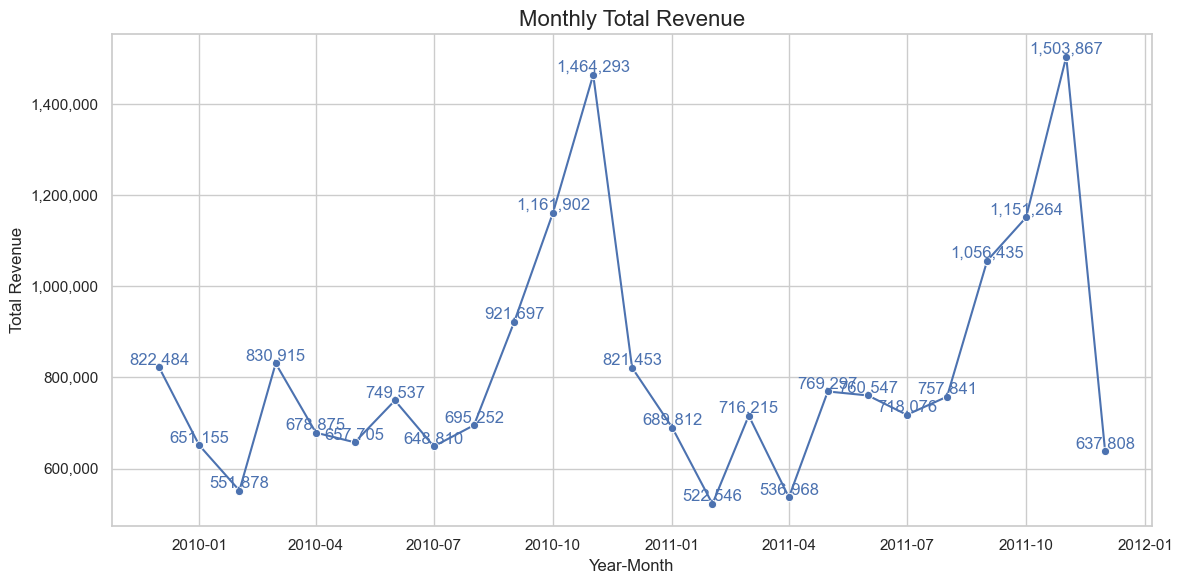

In [66]:
monthly_summary_pd = monthly_summary.to_pandas()

monthly_summary_pd['Year-Month'] = monthly_summary_pd['Year'].astype(str) + '-' + monthly_summary_pd['Month'].astype(str).str.zfill(2)

monthly_summary_pd['Year-Month'] = pd.to_datetime(monthly_summary_pd['Year-Month'], format='%Y-%m')
monthly_summary_pd = monthly_summary_pd.sort_values('Year-Month')

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

sns.lineplot(data=monthly_summary_pd, x='Year-Month', y='Total Revenue', marker='o')

for line in plt.gca().lines:
    for x, y in zip(line.get_xdata(), line.get_ydata()):
        plt.text(x, y, f'{y:,.0f}', color=line.get_color(), ha='center', va='bottom')

formatter = FuncFormatter(lambda x, _: f'{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.title('Monthly Total Revenue', fontsize=16)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)

plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

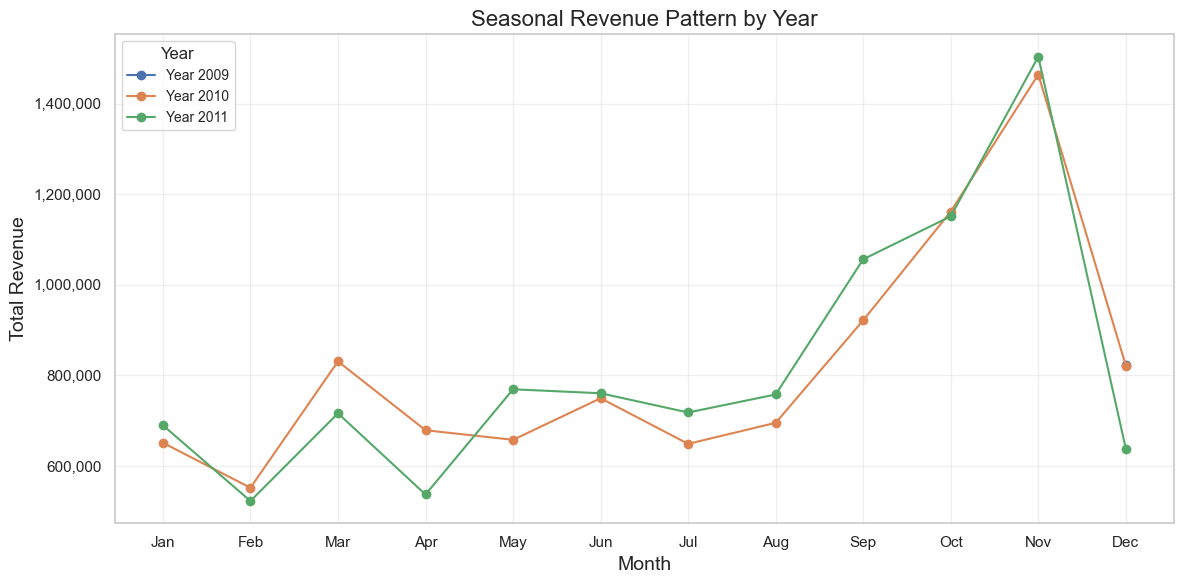

In [67]:
monthly_summary_pandas = monthly_summary.to_pandas()

pivoted_data = monthly_summary_pandas.pivot(index='Month', columns='Year', values='Total Revenue')

plt.figure(figsize=(12, 6))

for year in pivoted_data.columns:
    plt.plot(pivoted_data.index, pivoted_data[year], marker='o', label=f'Year {year}')

plt.title('Seasonal Revenue Pattern by Year', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Revenue', fontsize=14)
plt.xticks(range(1, 13), 
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year', fontsize=10)
plt.grid(alpha=0.3)

plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.show()

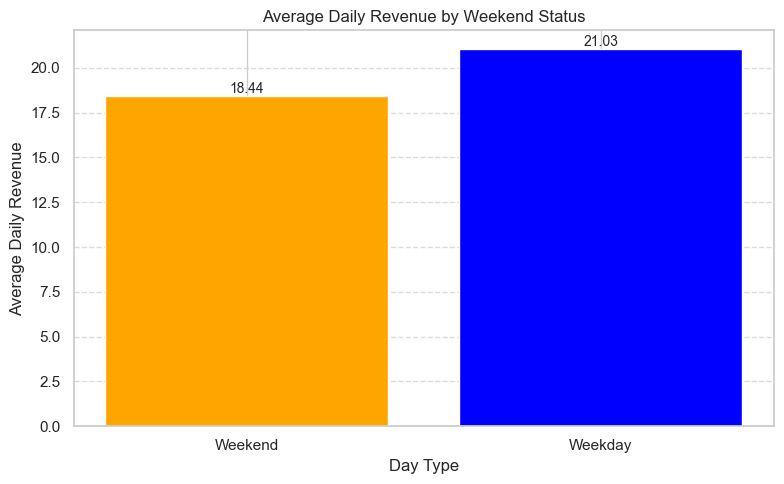

In [68]:
average_revenue = (
    df
    .group_by("IsWeekend")
    .agg(pl.col("Revenue").mean().alias("AverageRevenue"))
)

average_revenue_pd = average_revenue.to_pandas()

categories = ["Weekend" if is_weekend else "Weekday" for is_weekend in average_revenue_pd["IsWeekend"]]
values = average_revenue_pd["AverageRevenue"]

plt.figure(figsize=(8, 5))
bars = plt.bar(categories, values, color=["orange", "blue"])

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  
        height,  
        f"{height:.2f}",  
        ha='center',  
        va='bottom',  
        fontsize=10  
    )

plt.title("Average Daily Revenue by Weekend Status")
plt.ylabel("Average Daily Revenue")
plt.xlabel("Day Type")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [69]:
# summary per year, month, sort by total revenue in descending order

monthly_summary_by_rev = df.group_by('Year', 'Month').agg(
    pl.sum('Revenue').alias('Total Revenue'),
    pl.sum('Quantity').alias('Total Quantity')
).sort(by='Total Revenue', descending=True)

monthly_summary_by_rev

Year,Month,Total Revenue,Total Quantity
i32,i8,f64,i64
2011,11,1.5039e6,751377
2010,11,1.4643e6,725161
2010,10,1.1619e6,619996
2011,10,1.1513e6,621029
2011,9,1.0564e6,569573
…,…,…,…
2010,7,648810.27,337895
2011,12,637808.33,313613
2010,2,551878.296,381880


In [70]:
# # group df by keywords in descending order and get revenue per keyword. Let's see if can group properly this way 

# # result returned 801 groups 
# df.group_by('keyword').agg(
#     pl.count('Description'),
#     pl.sum('Revenue').alias('Revenue per Keyword')
# ).sort(by='Revenue per Keyword', descending = True)

In [71]:
# # group df by keywords, country encoded in descending order and get revenue per keyword. Let's see if can group properly this way 

# df.group_by('keyword', 'Country').agg(
#     pl.count('Description').alias('count'),
#     pl.sum('Revenue').alias('Revenue per Keyword')
# ).sort(by='Revenue per Keyword', descending = True)

## Image

In [72]:
# transfer data to pandas
pd_df = df.to_pandas()
pd_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Price_Outlier,Quantity_Outlier,...,Price_Normalised,Revenue,Year,Month,Day,Hour,Day Of Week,IsWeekend,Country_encoded,Is Domestic
0,526089,22606,WOODEN SKITTLES GARDEN SET,1,2010-10-08 12:14:00,15.95,15281.00,United Kingdom,True,False,...,0.00,15.95,2010,10,8,12,5,True,40,True
1,547652,84970L,SINGLE HEART ZINC T-LIGHT HOLDER,24,2011-03-24 12:15:00,0.95,14606.00,United Kingdom,False,False,...,0.00,22.80,2011,3,24,12,4,False,40,True
2,534378,22065,CHRISTMAS PUDDING TRINKET POT,6,2010-11-22 12:33:00,1.45,14461.00,United Kingdom,False,False,...,0.00,8.70,2010,11,22,12,1,False,40,True
3,545150,21523,DOORMAT FANCY FONT HOME SWEET HOME,2,2011-02-28 12:27:00,7.95,14227.00,United Kingdom,False,False,...,0.00,15.90,2011,2,28,12,1,False,40,True
4,524952,22595,CHRISTMAS GINGHAM HEART,6,2010-10-01 13:09:00,0.85,NaN,United Kingdom,False,False,...,0.00,5.10,2010,10,1,13,5,True,40,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007909,492953,51012C,"FEATHER DUSTER, COAL BLACK",12,2009-12-21 15:20:00,1.25,14505.00,United Kingdom,False,False,...,0.00,15.00,2009,12,21,15,1,False,40,True
1007910,491966,21364,PEACE SMALL WOOD LETTERS,1,2009-12-14 17:16:00,13.87,NaN,United Kingdom,True,False,...,0.00,13.87,2009,12,14,17,1,False,40,True
1007911,575117,23583,LUNCH BAG PAISLEY PARK,1,2011-11-08 14:22:00,1.65,12748.00,United Kingdom,False,False,...,0.00,1.65,2011,11,8,14,2,False,40,True
1007912,495578,84997B,RED 3 PIECE MINI DOTS CUTLERY SET,6,2010-01-26 09:51:00,3.75,13971.00,United Kingdom,False,False,...,0.00,22.50,2010,1,26,9,2,False,40,True


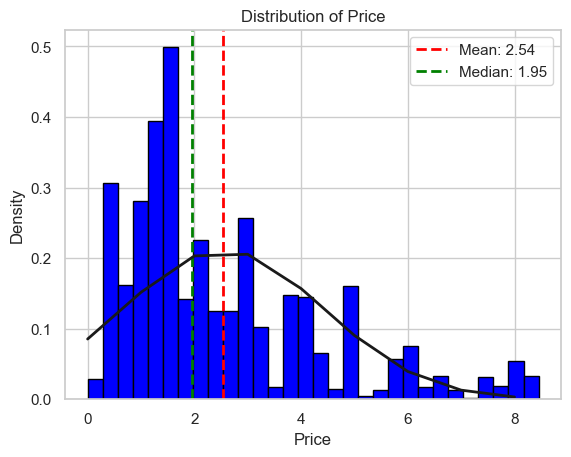

In [73]:
# Filter out extreme values
filtered_df = pd_df[~pd_df['Price_Outlier']]
# bar chart
n, bins, patches = plt.hist(filtered_df['Price'], bins=30, color='blue', edgecolor='black', density=True)
# curve
mean = filtered_df['Price'].mean()
median = filtered_df['Price'].median()
std = filtered_df['Price'].std()
xmin, xmax = plt.xlim()
x_values = [i for i in range(int(xmin), int(xmax)+1)]
normal_pdf = [(1 / (std * math.sqrt(2 * math.pi))) * math.exp(-0.5 * ((x - mean) / std) ** 2) for x in x_values]
# mean and median
plt.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(median, color='green', linestyle='--', linewidth=2, label=f'Median: {median:.2f}')
#some setting
plt.legend(loc='upper right')
plt.plot(x_values, normal_pdf, 'k', linewidth=2)
plt.title("Distribution of Price")
plt.xlabel("Price")
plt.ylabel("Density")
plt.show()

#  Regarding the removal of outliers, it was considered necessary as the dataset contains some exceptionally large values. Including these values caused the graph to stretch considerably, making it challenging to interpret in an image

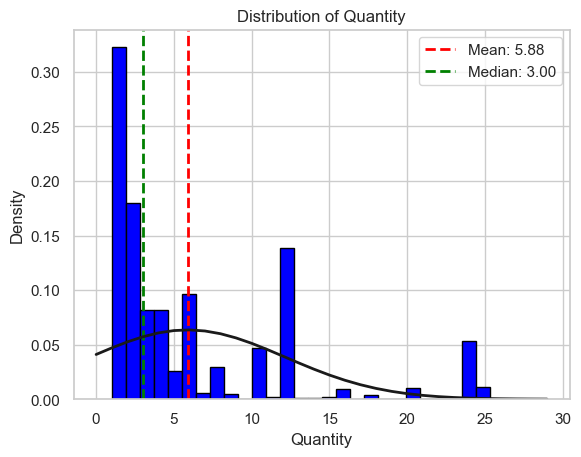

In [74]:
# Filter out extreme values
filtered_df = pd_df[~pd_df['Quantity_Outlier']]
# bar chart
n, bins, patches = plt.hist(filtered_df['Quantity'], bins=30, color='blue', edgecolor='black', density=True)
#curve line
mean = filtered_df['Quantity'].mean()
median = filtered_df['Quantity'].median()
std = filtered_df['Quantity'].std()
xmin, xmax = plt.xlim()
x_values = [i for i in range(int(xmin), int(xmax)+1)]
normal_pdf = [(1 / (std * math.sqrt(2 * math.pi))) * math.exp(-0.5 * ((x - mean) / std) ** 2) for x in x_values]
# mean and median
plt.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(median, color='green', linestyle='--', linewidth=2, label=f'Median: {median:.2f}')
#some setting
plt.legend(loc='upper right')
plt.plot(x_values, normal_pdf, 'k', linewidth=2)
plt.title("Distribution of Quantity")
plt.xlabel("Quantity")
plt.ylabel("Density")

plt.show()

In [75]:
# The two charts above represent the distribution of quantity and price, which, as predicted by Hector, are not normally distributed

In [76]:
# The following data will all be represented using pie charts, with quantity and revenue calculated separately
# Nash, feel free to choose whichever one you prefer, but I personally think revenue is more meaningful

In [77]:
# # Calculating how many product does customer buy in different group, there is no tyre and computer in the keyword
# q_e = pd_df[pd_df['keyword'].str.contains('Engine', case=False, na=False)]['Quantity'].sum()#amount of engine
# q_t = pd_df[pd_df['keyword'].str.contains('Tyre', case=False, na=False)]['Quantity'].sum()#amount of tyre
# q_k = pd_df[pd_df['keyword'].str.contains('Key', case=False, na=False)]['Quantity'].sum()#amount of key
# q_g = pd_df[pd_df['keyword'].str.contains('Glass', case=False, na=False)]['Quantity'].sum()#amount of glass
# q_pc = pd_df[pd_df['keyword'].str.contains('Computer', case=False, na=False)]['Quantity'].sum()#amount of computer
# q_c = pd_df[pd_df['keyword'].str.contains('Chair', case=False, na=False)]['Quantity'].sum()#amount of chair
# #Because the proportions of the engine and chair are too small, I combined them to improve the appearance of the pie chart
# labels = ['Engine & Chair', 'Key', 'Glass']
# sizes = [q_e + q_c, q_k, q_g]
# colors = ['gold', 'lightcoral', 'lightskyblue']
# # Create pie chart
# plt.figure(figsize=(7,7))
# plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
# # Title
# plt.title('Quantity Distribution by Product Category')
# # Show the chart
# plt.show()

In [78]:
# # Calculating how many money does customer spend in different group
# r_e = pd_df[pd_df['keyword'].str.contains('Engine', case=False, na=False)]['Revenue'].sum()#revenue of engine
# r_k = pd_df[pd_df['keyword'].str.contains('Key', case=False, na=False)]['Revenue'].sum()#revenue of key
# r_g = pd_df[pd_df['keyword'].str.contains('Glass', case=False, na=False)]['Revenue'].sum()#revenue of glass
# r_c = pd_df[pd_df['keyword'].str.contains('Chair', case=False, na=False)]['Revenue'].sum()#revenue of chair
# #The data in the pie chart
# labels = ['Engine & Chair', 'Key', 'Glass']
# sizes = [r_e + r_c, r_k, r_g]
# colors = ['gold', 'lightcoral', 'lightskyblue']
# # Create pie chart
# plt.figure(figsize=(7,7))
# plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
# # Title
# plt.title('Revenue Distribution by Product Category')
# # Show the chart
# plt.show()

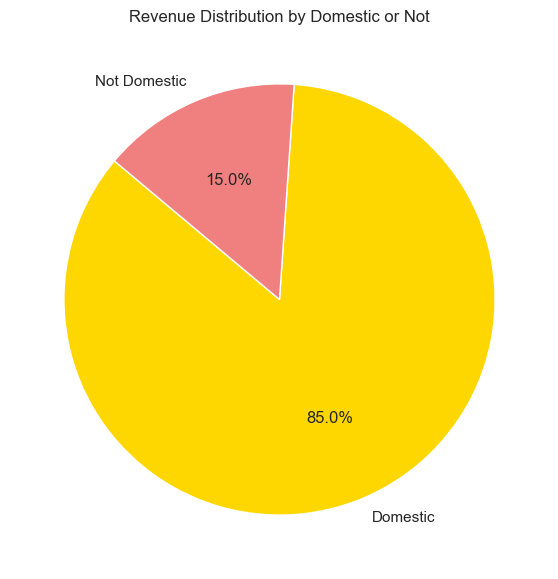

In [79]:
r_d = pd_df[pd_df['Is Domestic']]['Revenue'].sum()# total revenue by domestic customer
r_o = pd_df[~pd_df['Is Domestic']]['Revenue'].sum()# total revenue by foreign customer

labels = ['Domestic', 'Not Domestic']
sizes = [r_d, r_o]
colors = ['gold', 'lightcoral']
# Create pie chart
plt.figure(figsize=(7,7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
# Title
plt.title('Revenue Distribution by Domestic or Not')
# Show the chart
plt.show()

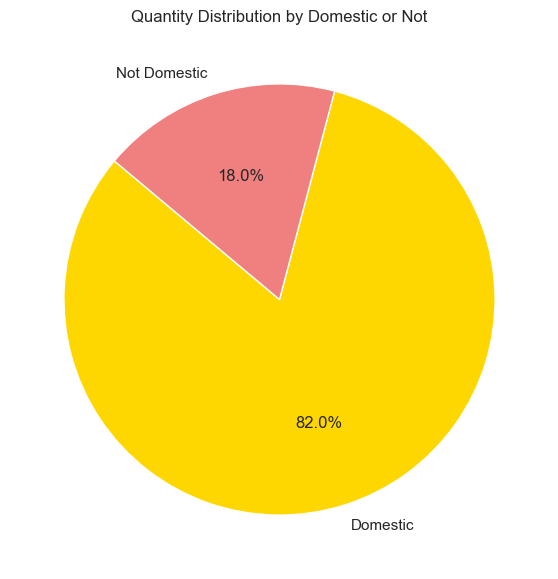

In [80]:
q_d = pd_df[pd_df['Is Domestic']]['Quantity'].sum()# total quantity by domestic customer
q_o = pd_df[~pd_df['Is Domestic']]['Quantity'].sum()# total quantity by foreign customer

labels = ['Domestic', 'Not Domestic']
sizes = [q_d, q_o]
colors = ['gold', 'lightcoral']
# Create pie chart
plt.figure(figsize=(7,7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
# Title
plt.title('Quantity Distribution by Domestic or Not')
# Show the chart
plt.show()

In [81]:
# It is clear that the majority of customers are from the UK, and there is significant potential for growth in the overseas market
#  Maybe can offering more incentives, etc., could help attract them

## Qvii

In [82]:
pd_df = df.to_pandas()
# Calculate the number of purchases for each ID
pd_df['purchase_count'] = pd_df.groupby('Customer ID')['Customer ID'].transform('count')
pd_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Price_Outlier,Quantity_Outlier,...,Revenue,Year,Month,Day,Hour,Day Of Week,IsWeekend,Country_encoded,Is Domestic,purchase_count
0,526089,22606,WOODEN SKITTLES GARDEN SET,1,2010-10-08 12:14:00,15.95,15281.00,United Kingdom,True,False,...,15.95,2010,10,8,12,5,True,40,True,522.00
1,547652,84970L,SINGLE HEART ZINC T-LIGHT HOLDER,24,2011-03-24 12:15:00,0.95,14606.00,United Kingdom,False,False,...,22.80,2011,3,24,12,4,False,40,True,6359.00
2,534378,22065,CHRISTMAS PUDDING TRINKET POT,6,2010-11-22 12:33:00,1.45,14461.00,United Kingdom,False,False,...,8.70,2010,11,22,12,1,False,40,True,636.00
3,545150,21523,DOORMAT FANCY FONT HOME SWEET HOME,2,2011-02-28 12:27:00,7.95,14227.00,United Kingdom,False,False,...,15.90,2011,2,28,12,1,False,40,True,377.00
4,524952,22595,CHRISTMAS GINGHAM HEART,6,2010-10-01 13:09:00,0.85,NaN,United Kingdom,False,False,...,5.10,2010,10,1,13,5,True,40,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007909,492953,51012C,"FEATHER DUSTER, COAL BLACK",12,2009-12-21 15:20:00,1.25,14505.00,United Kingdom,False,False,...,15.00,2009,12,21,15,1,False,40,True,1575.00
1007910,491966,21364,PEACE SMALL WOOD LETTERS,1,2009-12-14 17:16:00,13.87,NaN,United Kingdom,True,False,...,13.87,2009,12,14,17,1,False,40,True,NaN
1007911,575117,23583,LUNCH BAG PAISLEY PARK,1,2011-11-08 14:22:00,1.65,12748.00,United Kingdom,False,False,...,1.65,2011,11,8,14,2,False,40,True,6585.00
1007912,495578,84997B,RED 3 PIECE MINI DOTS CUTLERY SET,6,2010-01-26 09:51:00,3.75,13971.00,United Kingdom,False,False,...,22.50,2010,1,26,9,2,False,40,True,255.00


In [83]:
# result_7 is the new DataFrame to store the result
result_7 = pd_df.groupby('Customer ID')['purchase_count'].sum().reset_index()
# using for loop to distinguish customer-value
for index, row in result_7.iterrows():
    if row['purchase_count'] > 100:
        result_7.at[index, 'purchase_count'] = 'High-value'
    elif row['purchase_count'] >= 50:
        result_7.at[index, 'purchase_count'] = 'Medium-value'
    else:
        result_7.at[index, 'purchase_count'] = 'Low-value'
result_7

/var/folders/pl/vldk2f117ps7jbp86h049rxc0000gn/T/ipykernel_24474/2661513846.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'High-value' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  result_7.at[index, 'purchase_count'] = 'High-value'


,Customer ID,purchase_count
0,12346.00,High-value
1,12347.00,High-value
2,12348.00,High-value
3,12349.00,High-value
4,12350.00,High-value
...,...,...
5873,18283.00,High-value
5874,18284.00,High-value
5875,18285.00,High-value
5876,18286.00,High-value


In [84]:
customer_counts = result_7['purchase_count'].value_counts()
customer_counts

purchase_count
High-value      5130
Low-value        512
Medium-value     236
Name: count, dtype: int64

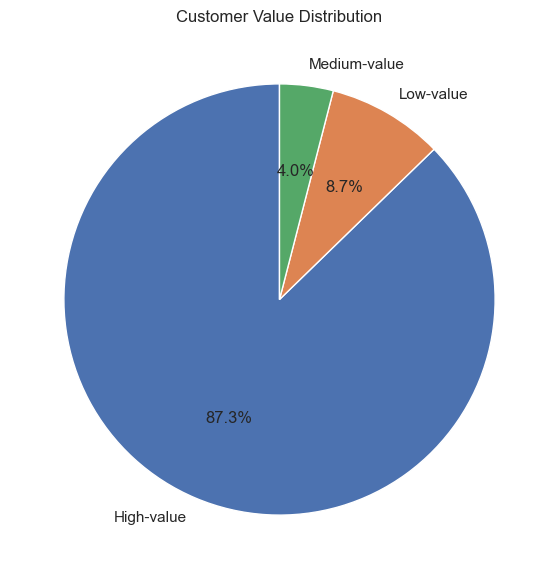

In [85]:
# turn result to pie chart
plt.figure(figsize=(7, 7))
customer_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Customer Value Distribution')
plt.ylabel('')
plt.show()

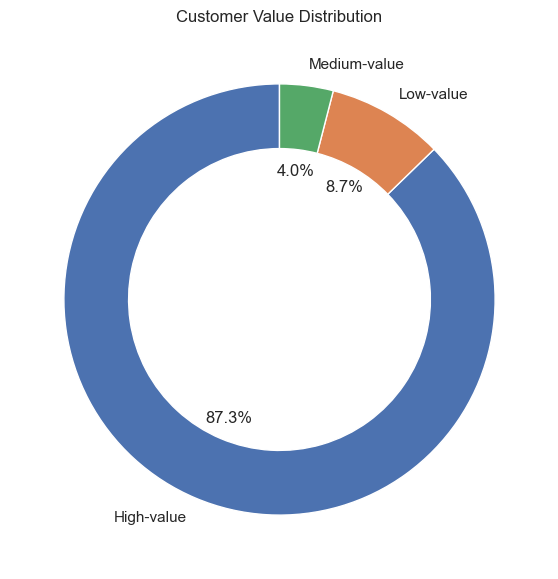

In [86]:
# check if donut chart looks better
plt.figure(figsize=(7, 7))
customer_counts.plot(
    kind='pie', 
    autopct='%1.1f%%', 
    startangle=90, 
    wedgeprops={'width': 0.3}  
)
plt.title('Customer Value Distribution')
plt.ylabel('')
plt.show()

In [87]:
# It is clear that the majority of customers have made multiple purchases, which indicates high customer loyalty
# However, it also suggests a lack of new customers. The company should find ways to expand its customer base

## Qviii

In [88]:
# all_months = pd.date_range(start="2009-12", end="2011-03", freq='MS')# set the range
# result_df = []# to store the result
# # to find the data we want and put into resuit_df
# for month in all_months:
#     month_data = []# the monthly sales data for each product
#     # find the data and append to month_data
#     for product in ['Engine', 'Key', 'Glass', 'Chair']:
#         filtered_df = pd_df[
#             (pd_df['Year'] == month.year) & 
#             (pd_df['Month'] == month.month) & 
#             (pd_df['keyword'].str.contains(product, case=False, na=False))
#         ]
#         revenue = filtered_df['Revenue'].sum() if not filtered_df.empty else 0# if empty it will be 0, make sure data is not Null
#         month_data.append(revenue)
#     result_df.append(month_data)# add each month result into result_df
# # Using numpy, create a 2D array that represents the monthly sales
# result_df = np.array(result_df)
# print(result_df)
# # linegraph
# plt.figure(figsize=(12, 6))
# for i, product in enumerate(['Engine', 'Key', 'Glass', 'Chair']):
#     plt.plot(
#         range(len(all_months)),
#         result_df[:, i],
#         marker='o',
#         label=product.capitalize()
#     )
# plt.title("Monthly Revenue for Products")
# plt.xlabel("Month")
# plt.ylabel("Revenue")
# plt.xticks(range(len(all_months)), [date.strftime("%Y-%m") for date in all_months], rotation=45)
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

In [89]:
# This chart, like the pie chart above, shows that GLASS is the most dominant product
# It also indicates that consumer spending tends to increase in the months of October, November, and December 
# The company should seize the opportunity to attract customers during this period

In [90]:
# products = ['Engine', 'Key', 'Glass', 'Chair']
# # total sales for each product
# total_sales = result_df.sum(axis=0)
# # find the highest sales month
# highest_sales = result_df.max(axis=0)# number
# highest_sales_month = result_df.argmax(axis=0)# the index that highest sale occured in result_df
# highest_sales_month_names = [all_months[idx].strftime("%Y-%m") for idx in highest_sales_month]# use index to find the month name
# # overall mean
# overall_mean = result_df.mean()
# # print
# print("Total sales for each product")
# for product, total_sales in zip(products, total_sales):
#     print(f"{product}: {total_sales:.2f}")
# print("\nHighest sales month:")
# for product, month, sales in zip(products, highest_sales_month_names, highest_sales):
#     print(f"{product}: {month} - {sales:.2f}")
# print(f"\nOverall mean: {overall_mean:.2f}")

In [91]:
products = ["Engine", "Tyre", "Key", "Glass", "Computer", "Chair"]
# create the random value into 2D array
sales_data = np.random.randint(100, 1001, (6, 12))
# the list to find the total sales for each product
total_sales_per_product = np.sum(sales_data, axis=1)
# the list to find the highest sales month for each product
highest_sales_month_per_product = np.argmax(sales_data, axis=1)
# find the overall mean
overall_mean_sales = np.mean(sales_data)
# print
print("Data set:\n", sales_data)
for i, product in enumerate(products):
    print(f"{product}:")
    print(f"  Total sales: {total_sales_per_product[i]}")
    print(f"  Highest sales month: {highest_sales_month_per_product[i]}")
print(f"\nOverall mean: {overall_mean_sales:.2f}")

Data set:
 [[204 939 857 307 838 224 360 631 168 832 989 564]
 [582 430 989 875 234 716 490 665 958 639 458 480]
 [209 913 324 463 947 102 567 493 772 888 333 993]
 [268 263 490 162 677 411 421 415 490 382 862 801]
 [870 984 725 312 672 771 908 527 667 366 514 256]
 [839 181 720 999 144 666 821 337 420 128 630 172]]
Engine:
  Total sales: 6913
  Highest sales month: 10
Tyre:
  Total sales: 7516
  Highest sales month: 2
Key:
  Total sales: 7004
  Highest sales month: 11
Glass:
  Total sales: 5642
  Highest sales month: 10
Computer:
  Total sales: 7572
  Highest sales month: 1
Chair:
  Total sales: 6057
  Highest sales month: 3

Overall mean: 565.33


In [92]:
df

Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Price_Outlier,Quantity_Outlier,Quantity_Normalised,Price_Normalised,Revenue,Year,Month,Day,Hour,Day Of Week,IsWeekend,Country_encoded,Is Domestic
str,str,str,i64,datetime[ns],f64,f64,str,bool,bool,f64,f64,f64,i32,i8,i8,i8,i8,bool,i64,bool
"""526089""","""22606""","""WOODEN SKITTLES GARDEN SET""",1,2010-10-08 12:14:00,15.95,15281.0,"""United Kingdom""",true,false,0.0,0.000635,15.95,2010,10,8,12,5,true,40,true
"""547652""","""84970L""","""SINGLE HEART ZINC T-LIGHT HOLD…",24,2011-03-24 12:15:00,0.95,14606.0,"""United Kingdom""",false,false,0.000284,0.000038,22.8,2011,3,24,12,4,false,40,true
"""534378""","""22065""","""CHRISTMAS PUDDING TRINKET POT """,6,2010-11-22 12:33:00,1.45,14461.0,"""United Kingdom""",false,false,0.000062,0.000058,8.7,2010,11,22,12,1,false,40,true
"""545150""","""21523""","""DOORMAT FANCY FONT HOME SWEET …",2,2011-02-28 12:27:00,7.95,14227.0,"""United Kingdom""",false,false,0.000012,0.000317,15.9,2011,2,28,12,1,false,40,true
"""524952""","""22595""","""CHRISTMAS GINGHAM HEART""",6,2010-10-01 13:09:00,0.85,null,"""United Kingdom""",false,false,0.000062,0.000034,5.1,2010,10,1,13,5,true,40,true
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""492953""","""51012C""","""FEATHER DUSTER, COAL BLACK""",12,2009-12-21 15:20:00,1.25,14505.0,"""United Kingdom""",false,false,0.000136,0.00005,15.0,2009,12,21,15,1,false,40,true
"""491966""","""21364""","""PEACE SMALL WOOD LETTERS""",1,2009-12-14 17:16:00,13.87,null,"""United Kingdom""",true,false,0.0,0.000552,13.87,2009,12,14,17,1,false,40,true
"""575117""","""23583""","""LUNCH BAG PAISLEY PARK """,1,2011-11-08 14:22:00,1.65,12748.0,"""United Kingdom""",false,false,0.0,0.000066,1.65,2011,11,8,14,2,false,40,true
